In [1]:
import pandas as pd
import pathlib
import numpy as np
import torch.nn as nn
import seaborn as sns

from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from tqdm import tqdm

#local imports
#from preprocess import run_pipeline

In [2]:
%matplotlib inline

## 1. Configure local `data` directory for S3 upload

I already handled this in the **2-CNN_From_Scratch** notebook, and it took a long time, so the only cell I am doing to need to execute here is establishing a path to my local `data` directory.

In [3]:
data_dir = pathlib.Path('data')
if not data_dir.exists():
    data_dir.mkdir()

### Only run this section if you haven't yet in your local environment and/or sagemaker notebook environment!

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar -O data/temp.tar
!tar xofp data/temp.tar -C data
!rm data/temp.tar

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -O data/temp.tar
!tar xofp data/temp.tar -C data
!rm data/temp.tar

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -O data/temp.tar
!tar xofp data/temp.tar -C data
!rm data/temp.tar

In [ ]:
run_pipeline(root_dir = data_dir)

## 2. Create Necessary Sagemaker and S3 roles and pointers

In [4]:
import boto3
import sagemaker
from sagemaker import get_execution_role

Because of odd versioning errors when I first spun up this notebook instance, I **created my own** s3 bucket called `sagemaker-dogproj`. So when I instantiate this session, I am setting that as the default bucket.

In [5]:
sagemaker_session = sagemaker.Session(default_bucket = "sagemaker-dogproj")
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

In [6]:
bucket

'sagemaker-dogproj'

In [7]:
bucket_train_prefix = "train"

Because the images are already up there in the s3 bucket, I can simply construct my `train_data_path` with good old fashioned string formatting

In [8]:
train_data_path = f"s3://{bucket}/{bucket_train_prefix}"
train_data_path

's3://sagemaker-dogproj/train'

## 3. Explore how to manipulate pre-trained models

#### Note

The cells in this section were executed _locally only,_ because every time you instantiate a `torchvision.models` class it will download the architecture to local storage. Given how memory constrained these Notebook Instances are, I wanted to hold off on doing that.

Suffice it to say, the same general process that you see for each of the three models below has been refactored into the `_get_pretrained_model()` function within `sourceTransferLearn/train.py`

Bringing in a state-of-the-art image classification model in PyTorch is as simple as this ...

#### VGG-16

In [13]:
model = models.vgg16(pretrained = True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Following the recommendations in [this transfer learning example](https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb) we will only retrain the *last Linear layer* of the `classifier` portion of VGG-16, replacing it with something that outputs predictions for our 120 dog breeds instead of the 1000 classes of ImageNet

This means we should...

- freeze all layers of the model
- remove sixth layer of the classifier
- replace it with something else

I followed the transfer learning example here by adding two dense layers that gradually reduce the 4,096-dimensional output of VGG-16 to 512, apply 33% dropout, then reducing the dimensionality to the number of classes before applying our LogSoftmax transformation to prepare for the use of Negative Log Likelihood loss. 

In [14]:
for param in model.parameters():
    param.requires_grad = False

In [15]:
num_inputs = model.classifier[6].in_features
n_classes = 120

model.classifier[6] = nn.Sequential(
    nn.Linear(in_features = num_inputs, out_features = 512),
    nn.ReLU(),
    nn.Dropout(0.33),
    nn.Linear(in_features = 512, out_features = n_classes),
    nn.LogSoftmax(dim = 1)
)

Here's what the model looks like now ...

In [16]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Here is a way to prove that we are actually _transfer_ learning: keeping the general, convolutional parameters static while only re-learning the ones that allow us to make a more specific classification.

In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")

Total Parameters: 136,419,768


In [18]:
train_params = (sum(p.numel() for p in model.parameters() if p.requires_grad))
print(f"Trainable Parameters: {train_params:,}")

Trainable Parameters: 2,159,224


So even though we still have 2.2 million parameters to train, this is only about 1.6% of the total space of the model. One of the things that I will need to keep in mind here is making sure whether this will fit on the `ml.p2.xlarge` instances that sagemaker provides.

**This general process of freezing the parameters and attaching a smaller, trainable classifier should work at a high level for any of the pretrained models in PyTorch**

I'd like to try and look at some of the other models available in Pytorch to understand the size of things I would be bringing in...

#### ResNet50

In [31]:
model = models.resnet50(pretrained = True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In this case, we'd only want to remove the `fc` layer at the very end of things

In [32]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [33]:
for param in model.parameters():
    param.requires_grad = False

In [34]:
num_inputs = model.fc.in_features
n_classes = 120

model.fc = nn.Sequential(
    nn.Linear(in_features = num_inputs, out_features = 512),
    nn.ReLU(),
    nn.Dropout(0.33),
    nn.Linear(in_features = 512, out_features = n_classes),
    nn.LogSoftmax(dim = 1)
)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Train Parameters: {train_params:,}")

Total Parameters: 24,618,680
Train Parameters: 1,110,648


Resnet50 has fewer overall parameters than VGG16, so I'm a bit more optimistic about loading this one onto AWS's GPUs...

#### GoogLeNet

In [36]:
model = models.googlenet(pretrained = True)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

This is similar to working with ResNet; we just want to remove the final `fc` layer.

In [37]:
for param in model.parameters():
    param.requires_grad = False

In [38]:
num_inputs = model.fc.in_features
n_classes = 120

model.fc = nn.Sequential(
    nn.Linear(in_features = num_inputs, out_features = 512),
    nn.ReLU(),
    nn.Dropout(0.33),
    nn.Linear(in_features = 512, out_features = n_classes),
    nn.LogSoftmax(dim = 1)
)

model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [39]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Train Parameters: {train_params:,}")

Total Parameters: 6,186,264
Train Parameters: 586,360


Even smaller than ResNet! I think, for the time being, writing a `train.py` script that can handle these three pre-trained models (`vgg16`, `resnet50`,`googlenet`) should be a good group of architectures to experiment with.

Of course, constraints of runtime and memory will play a role here, but I'll know more once I get to Sagemaker. 

## 4. Train, Deploy, Inference: VGG-16

Here begins a transfer learning process that I am going to attempt to repeat for the three architectures above:

- Train a version off the architecture where the only weights re-learned are those involved in a 120-class sequential classification layer tacked on the the end of the convolution layers.
- Deploy that version to a Sagemaker Endpoint (_I want to try using the `ml.p2.xlarge` instance_).
- Perform inference on the test set and save the results to a data frame
- Create visualizations of that performance

I'll start with VGG-16 because this is the architecture that I see used most frequently in Transfer Learning applications. It's also the largest of the pretrained models, so I think it'll be a good test case for space constraints.

Here is how we can set up a training job using our transfer learning code instead of our ground-up code. Note that I am changing `source_dir` to point to the appropriate directory, and that I am adding three hyperparameters to specify which architecture I am using for transfer learning and some parameters of the sequential classifier I am appending.

In [9]:
from sagemaker.pytorch import PyTorch

output_path = f"s3://{bucket}/model-output"

estimator = PyTorch(entry_point = "train.py",
                    source_dir = "sourceTransferLearn",
                    role = role,
                    framework_version = "1.5.0",
                    train_instance_count = 1, 
                    train_instance_type = "ml.p2.xlarge",
                    output_path = output_path,
                    sagemaker_session = sagemaker_session, 
                    hyperparameters = {
                        "epochs": 20,
                        "batch-size": 128,
                        "model_name":"vgg16",
                        "hidden_units":512,
                        "dropout":0.33
                    })

In [10]:
%%time
estimator.fit({"train":train_data_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-06-24 14:48:40 Starting - Starting the training job...
2020-06-24 14:48:42 Starting - Launching requested ML instances......
2020-06-24 14:49:45 Starting - Preparing the instances for training......
2020-06-24 14:51:08 Downloading - Downloading input data............
2020-06-24 14:53:12 Training - Downloading the training image....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-24 14:53:44,604 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-24 14:53:44,628 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-24 14:53:44,876 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-24 14:53:45,149 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-06-24 14:53:45,149 sagemaker-containers INFO     Generating setup.cfg
2020-06-24 14:53

Epoch 16, Loss 0.8066, Accuracy: 74.57%
Epoch 17, Loss 0.7872, Accuracy: 74.89%
Epoch 18, Loss 0.7846, Accuracy: 74.92%
Epoch 19, Loss 0.7866, Accuracy: 75.30%
Epoch 20, Loss 0.7769, Accuracy: 75.27%
[2020-06-24 15:50:07.841 algo-1:43 INFO utils.py:25] The end of training job file will not be written for jobs running under SageMaker.
2020-06-24 15:50:08,907 sagemaker-containers INFO     Reporting training SUCCESS

2020-06-24 15:50:13 Uploading - Uploading generated training model
2020-06-24 15:51:31 Completed - Training job completed
Training seconds: 3623
Billable seconds: 3623
CPU times: user 8.63 s, sys: 291 ms, total: 8.92 s
Wall time: 1h 3min 26s


In [18]:
estimator.model_data

's3://sagemaker-dogproj/model-output/pytorch-training-2020-06-24-14-48-40-304/output/model.tar.gz'

# TODO

Revisit everything below this cell in the remainder of this section. If restarting the notebook instance, swap `estimator.model_data` with `vgg16_model_data`.

In [23]:
vgg_training_job = "pytorch-training-2020-06-24-14-48-40-304"
vgg16_model_data = f"{output_path}/{vgg_training_job}/output/model.tar.gz"
vgg16_model_data

's3://sagemaker-dogproj/model-output/pytorch-training-2020-06-24-14-48-40-304/output/model.tar.gz'

In [14]:
from sagemaker.pytorch import PyTorchModel
model = PyTorchModel(model_data = estimator.model_data, 
                     role = role, 
                     framework_version = "1.5.0",
                     entry_point = "predict.py", 
                     source_dir = "sourceTransferLearn")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [15]:
%%time
predictor = model.deploy(initial_instance_count = 1, instance_type = "ml.p2.xlarge")

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------------!CPU times: user 40.4 s, sys: 4.56 s, total: 44.9 s
Wall time: 11min 18s


I've experimented with bumping the batch size up to 3 and didn't get any netword errors. I don't think that's going to be the bottleneck here, though.

In [19]:
image_transforms = {
    "train":
    transforms.Compose([
        transforms.RandomResizedCrop(size = 256, scale = (0.85, 1.0)),
        transforms.RandomRotation(degrees = 20),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test":
    transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
test_img_folder = datasets.ImageFolder(root = data_dir / "test",
                                   transform = image_transforms["test"])
test_data_loader = DataLoader(dataset = test_img_folder, batch_size = 1, shuffle = True)
class_to_idx = test_data_loader.dataset.class_to_idx
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

In [20]:
test_acc_objs = []

for feat_batch, label_batch in tqdm(test_data_loader):
    label_batch = label_batch.numpy()
    feat_batch = feat_batch.numpy()
    output = predictor.predict(feat_batch)
    classes = output[0]
    probs = output[1]
    for i, preds in enumerate(classes):
        act_label = label_batch[i]
        acc_dict = {}
        acc_dict["predicted_labels"] = preds.tolist()
        acc_dict["predicted_classes"] = [idx_to_class[k] for k in preds.tolist()]
        acc_dict["predicted_probs"] = probs[i].tolist()
        acc_dict["actual_label"] = act_label
        acc_dict["actual_class"] = idx_to_class[act_label]
        acc_dict["top_one_acc"] = int(act_label == preds[0])
        acc_dict["top_five_acc"] = int(np.any(act_label == preds))
        test_acc_objs.append(acc_dict)

test_df = pd.DataFrame(data = test_acc_objs)  


  1%|▏         | 116/9249 [01:47<5:16:26,  2.08s/it]

KeyboardInterrupt: 

In [21]:
sagemaker_session.delete_endpoint(predictor.endpoint)

In [ ]:
n_test = len(test_df)
print(f"Top-One Accuracy was {test_df.top_one_acc.sum() / n_test:.2%}")
print(f"Top-Five Accuracy was {test_df.top_five_acc.sum() / n_test:.2%}")

In [ ]:
breed_agg = {"top_one_acc":"sum", 
             "top_five_acc":"sum", 
             "actual_label": "count"
            }
acc_by_breed = test_df.groupby(by = "actual_class").agg(breed_agg)
for col in ["top_one_acc", "top_five_acc"]:
    acc_by_breed[col] = acc_by_breed[col] / acc_by_breed.actual_label
acc_by_breed.rename(columns = {"actual_label":"num_instances"}, inplace = True)
acc_by_breed.describe()

In [ ]:
import seaborn as sns

In [ ]:
sns.set_style("whitegrid")
sns.lmplot(x = "num_instances", y = "top_one_acc", 
           data = acc_by_breed, ci = None, line_kws = {"color":"red"})
ax = plt.gca()
ax.set_title("VGG16 - Breed-Level Top 1 Accuracy \nBy Number of Test Instances")

In [ ]:
sns.set_style("whitegrid")
sns.lmplot(x = "num_instances", y = "top_five_acc", 
           data = acc_by_breed, ci = None, line_kws = {"color":"red"})
ax = plt.gca()
ax.set_title("VGG16 - Breed-Level Top 5 Accuracy \nBy Number of Test Instances")

In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
sns.set_style("whitegrid")
order = acc_by_breed["top_one_acc"].sort_values(ascending = False).index.tolist()
acc_plot = sns.barplot(x = "actual_class", 
            y = "top_one_acc", 
            order = order,
            color = "green",
            ci = None,
            ax = ax,
            n_boot = None,
            data = test_df)
acc_plot.set_xticklabels(acc_plot.get_xticklabels(),
                         rotation = 75,
                         ha= 'right'
                        )
plt.title("VGG16 - Top One Accuracy by Breed")
plt.tight_layout()

In [ ]:
pd.cut(acc_by_breed.top_one_acc, bins = np.linspace(0,1,11), 
       right = False, include_lowest = True).value_counts(normalize = True).sort_index()

In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
sns.set_style("whitegrid")
order = acc_by_breed["top_five_acc"].sort_values(ascending = False).index.tolist()
acc_plot = sns.barplot(x = "actual_class", 
            y = "top_five_acc", 
            order = order,
            color = "green",
            ci = None,
            ax = ax,
            n_boot = None,
            data = test_df)
acc_plot.set_xticklabels(acc_plot.get_xticklabels(),
                         rotation = 75,
                         ha= 'right'
                        )
plt.title("VGG16 - Top Five Accuracy by Breed")
plt.tight_layout()

In [ ]:
pd.cut(acc_by_breed.top_five_acc, bins = np.linspace(0,1,11), 
       right = False, include_lowest = True).value_counts(normalize = True).sort_index()

**What can you conclude??**

## 5. Train, Deploy, Inference: ResNet 50

In [24]:
estimator = PyTorch(entry_point = "train.py",
                    source_dir = "sourceTransferLearn",
                    role = role,
                    framework_version = "1.5.0",
                    train_instance_count = 1, 
                    train_instance_type = "ml.p2.xlarge",
                    output_path = output_path,
                    sagemaker_session = sagemaker_session, 
                    hyperparameters = {
                        "epochs": 20,
                        "batch-size": 128,
                        "model_name":"resnet50",
                        "hidden_units":512,
                        "dropout":0.33
                    })

In [25]:
%%time
estimator.fit({"train":train_data_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-06-24 17:39:29 Starting - Starting the training job...
2020-06-24 17:39:32 Starting - Launching requested ML instances.........
2020-06-24 17:41:04 Starting - Preparing the instances for training......
2020-06-24 17:42:04 Downloading - Downloading input data............
2020-06-24 17:44:06 Training - Downloading the training image...
2020-06-24 17:44:56 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-24 17:44:57,863 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-24 17:44:57,888 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-24 17:44:57,892 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-24 17:44:58,184 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py


Epoch 15, Loss 0.7968, Accuracy: 75.37%
Epoch 16, Loss 0.7901, Accuracy: 75.48%
Epoch 17, Loss 0.7891, Accuracy: 75.37%
Epoch 18, Loss 0.7751, Accuracy: 75.98%
Epoch 19, Loss 0.7561, Accuracy: 76.58%
Epoch 20, Loss 0.7473, Accuracy: 77.28%
[2020-06-24 18:31:07.756 algo-1:43 INFO utils.py:25] The end of training job file will not be written for jobs running under SageMaker.
2020-06-24 18:31:08,222 sagemaker-containers INFO     Reporting training SUCCESS

2020-06-24 18:31:28 Uploading - Uploading generated training model
2020-06-24 18:31:28 Completed - Training job completed
Training seconds: 2964
Billable seconds: 2964
CPU times: user 7.17 s, sys: 248 ms, total: 7.42 s
Wall time: 52min 16s


In [26]:
estimator.model_data

's3://sagemaker-dogproj/model-output/pytorch-training-2020-06-24-17-39-29-575/output/model.tar.gz'

In [27]:
resnet_training_job = "pytorch-training-2020-06-24-17-39-29-575"
resnet_model_data = f"{output_path}/{resnet_training_job}/output/model.tar.gz"
resnet_model_data

's3://sagemaker-dogproj/model-output/pytorch-training-2020-06-24-17-39-29-575/output/model.tar.gz'

In [53]:
model = PyTorchModel(model_data = resnet_model_data, 
                     role = role, 
                     framework_version = "1.5.0",
                     entry_point = "predict.py", 
                     source_dir = "sourceTransferLearn")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [54]:
%%time
predictor = model.deploy(initial_instance_count = 1, instance_type = "ml.t2.medium")

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------------!CPU times: user 8.43 s, sys: 868 ms, total: 9.3 s
Wall time: 9min 41s


In [55]:
image_transforms = {
    "train":
    transforms.Compose([
        transforms.RandomResizedCrop(size = 256, scale = (0.85, 1.0)),
        transforms.RandomRotation(degrees = 20),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test":
    transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
test_img_folder = datasets.ImageFolder(root = data_dir / "test",
                                   transform = image_transforms["test"])
test_data_loader = DataLoader(dataset = test_img_folder, batch_size = 3, shuffle = True)
class_to_idx = test_data_loader.dataset.class_to_idx
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

In [56]:
test_acc_objs = []

for feat_batch, label_batch in tqdm(test_data_loader):
    label_batch = label_batch.numpy()
    feat_batch = feat_batch.numpy()
    output = predictor.predict(feat_batch)
    classes = output[0]
    probs = output[1]
    for i, preds in enumerate(classes):
        act_label = label_batch[i]
        acc_dict = {}
        acc_dict["predicted_labels"] = preds.tolist()
        acc_dict["predicted_classes"] = [idx_to_class[k] for k in preds.tolist()]
        acc_dict["predicted_probs"] = probs[i].tolist()
        acc_dict["actual_label"] = act_label
        acc_dict["actual_class"] = idx_to_class[act_label]
        acc_dict["top_one_acc"] = int(act_label == preds[0])
        acc_dict["top_five_acc"] = int(np.any(act_label == preds))
        test_acc_objs.append(acc_dict)

test_df = pd.DataFrame(data = test_acc_objs)  



  0%|          | 0/3083 [00:00<?, ?it/s]

  0%|          | 1/3083 [00:00<46:58,  1.09it/s]

  0%|          | 2/3083 [00:01<42:26,  1.21it/s]

  0%|          | 3/3083 [00:02<39:20,  1.30it/s]

  0%|          | 4/3083 [00:02<36:49,  1.39it/s]

  0%|          | 5/3083 [00:03<36:43,  1.40it/s]

  0%|          | 6/3083 [00:04<35:02,  1.46it/s]

  0%|          | 7/3083 [00:04<33:55,  1.51it/s]

  0%|          | 8/3083 [00:05<33:24,  1.53it/s]

  0%|          | 9/3083 [00:05<32:37,  1.57it/s]

  0%|          | 10/3083 [00:06<31:57,  1.60it/s]

  0%|          | 11/3083 [00:07<31:41,  1.62it/s]

  0%|          | 12/3083 [00:07<31:24,  1.63it/s]

  0%|          | 13/3083 [00:08<31:21,  1.63it/s]

  0%|          | 14/3083 [00:08<31:11,  1.64it/s]

  0%|          | 15/3083 [00:09<31:08,  1.64it/s]

  1%|          | 16/3083 [00:10<31:20,  1.63it/s]

  1%|          | 17/3083 [00:10<31:12,  1.64it/s]

  1%|          | 18/3083 [00:11<31:13,  1.64it/s]

  1%|          | 19/3083 [00:12<31:20,  1.63it/

  5%|▍         | 142/3083 [01:58<1:30:54,  1.85s/it]

  5%|▍         | 143/3083 [01:59<1:28:13,  1.80s/it]

  5%|▍         | 144/3083 [02:01<1:31:44,  1.87s/it]

  5%|▍         | 145/3083 [02:03<1:30:24,  1.85s/it]

  5%|▍         | 146/3083 [02:05<1:28:51,  1.82s/it]

  5%|▍         | 147/3083 [02:07<1:30:11,  1.84s/it]

  5%|▍         | 148/3083 [02:08<1:29:41,  1.83s/it]

  5%|▍         | 149/3083 [02:10<1:30:54,  1.86s/it]

  5%|▍         | 150/3083 [02:12<1:31:27,  1.87s/it]

  5%|▍         | 151/3083 [02:14<1:26:49,  1.78s/it]

  5%|▍         | 152/3083 [02:16<1:28:10,  1.81s/it]

  5%|▍         | 153/3083 [02:18<1:28:09,  1.81s/it]

  5%|▍         | 154/3083 [02:19<1:24:09,  1.72s/it]

  5%|▌         | 155/3083 [02:21<1:29:24,  1.83s/it]

  5%|▌         | 156/3083 [02:23<1:29:24,  1.83s/it]

  5%|▌         | 157/3083 [02:25<1:31:01,  1.87s/it]

  5%|▌         | 158/3083 [02:27<1:33:06,  1.91s/it]

  5%|▌         | 159/3083 [02:29<1:29:36,  1.84s/it]

  5%|▌         | 160/3083 [0

  9%|▉         | 281/3083 [04:24<27:49,  1.68it/s]

  9%|▉         | 282/3083 [04:25<28:15,  1.65it/s]

  9%|▉         | 283/3083 [04:26<28:03,  1.66it/s]

  9%|▉         | 284/3083 [04:26<28:08,  1.66it/s]

  9%|▉         | 285/3083 [04:27<28:05,  1.66it/s]

  9%|▉         | 286/3083 [04:27<27:56,  1.67it/s]

  9%|▉         | 287/3083 [04:28<28:38,  1.63it/s]

  9%|▉         | 288/3083 [04:29<28:35,  1.63it/s]

  9%|▉         | 289/3083 [04:29<28:26,  1.64it/s]

  9%|▉         | 290/3083 [04:30<28:16,  1.65it/s]

  9%|▉         | 291/3083 [04:31<28:03,  1.66it/s]

  9%|▉         | 292/3083 [04:31<27:49,  1.67it/s]

 10%|▉         | 293/3083 [04:32<27:50,  1.67it/s]

 10%|▉         | 294/3083 [04:32<27:49,  1.67it/s]

 10%|▉         | 295/3083 [04:33<28:08,  1.65it/s]

 10%|▉         | 296/3083 [04:34<28:11,  1.65it/s]

 10%|▉         | 297/3083 [04:34<28:44,  1.62it/s]

 10%|▉         | 298/3083 [04:35<28:35,  1.62it/s]

 10%|▉         | 299/3083 [04:35<28:29,  1.63it/s]

 10%|▉      

 14%|█▎        | 418/3083 [08:09<1:28:33,  1.99s/it]

 14%|█▎        | 419/3083 [08:11<1:30:46,  2.04s/it]

 14%|█▎        | 420/3083 [08:13<1:29:35,  2.02s/it]

 14%|█▎        | 421/3083 [08:15<1:29:12,  2.01s/it]

 14%|█▎        | 422/3083 [08:17<1:25:16,  1.92s/it]

 14%|█▎        | 423/3083 [08:19<1:27:18,  1.97s/it]

 14%|█▍        | 424/3083 [08:21<1:28:43,  2.00s/it]

 14%|█▍        | 425/3083 [08:23<1:29:33,  2.02s/it]

 14%|█▍        | 426/3083 [08:25<1:30:28,  2.04s/it]

 14%|█▍        | 427/3083 [08:27<1:31:28,  2.07s/it]

 14%|█▍        | 428/3083 [08:29<1:35:28,  2.16s/it]

 14%|█▍        | 429/3083 [08:31<1:30:38,  2.05s/it]

 14%|█▍        | 430/3083 [08:33<1:21:50,  1.85s/it]

 14%|█▍        | 431/3083 [08:33<1:05:03,  1.47s/it]

 14%|█▍        | 432/3083 [08:34<53:22,  1.21s/it]  

 14%|█▍        | 433/3083 [08:34<45:38,  1.03s/it]

 14%|█▍        | 434/3083 [08:35<39:52,  1.11it/s]

 14%|█▍        | 435/3083 [08:36<35:44,  1.23it/s]

 14%|█▍        | 436/3083 [08:36<3

 18%|█▊        | 558/3083 [10:18<1:16:26,  1.82s/it]

 18%|█▊        | 559/3083 [10:19<1:14:39,  1.77s/it]

 18%|█▊        | 560/3083 [10:21<1:13:05,  1.74s/it]

 18%|█▊        | 561/3083 [10:23<1:14:11,  1.77s/it]

 18%|█▊        | 562/3083 [10:25<1:15:58,  1.81s/it]

 18%|█▊        | 563/3083 [10:27<1:16:08,  1.81s/it]

 18%|█▊        | 564/3083 [10:29<1:16:44,  1.83s/it]

 18%|█▊        | 565/3083 [10:31<1:23:03,  1.98s/it]

 18%|█▊        | 566/3083 [10:33<1:20:29,  1.92s/it]

 18%|█▊        | 567/3083 [10:34<1:18:55,  1.88s/it]

 18%|█▊        | 568/3083 [10:36<1:15:40,  1.81s/it]

 18%|█▊        | 569/3083 [10:38<1:16:46,  1.83s/it]

 18%|█▊        | 570/3083 [10:40<1:17:12,  1.84s/it]

 19%|█▊        | 571/3083 [10:42<1:17:15,  1.85s/it]

 19%|█▊        | 572/3083 [10:43<1:14:09,  1.77s/it]

 19%|█▊        | 573/3083 [10:45<1:15:21,  1.80s/it]

 19%|█▊        | 574/3083 [10:47<1:16:07,  1.82s/it]

 19%|█▊        | 575/3083 [10:49<1:15:33,  1.81s/it]

 19%|█▊        | 576/3083 [1

 23%|██▎       | 695/3083 [13:51<24:05,  1.65it/s]

 23%|██▎       | 696/3083 [13:51<24:14,  1.64it/s]

 23%|██▎       | 697/3083 [13:52<24:13,  1.64it/s]

 23%|██▎       | 698/3083 [13:53<24:00,  1.66it/s]

 23%|██▎       | 699/3083 [13:53<23:53,  1.66it/s]

 23%|██▎       | 700/3083 [13:54<23:49,  1.67it/s]

 23%|██▎       | 701/3083 [13:54<23:42,  1.67it/s]

 23%|██▎       | 702/3083 [13:55<23:43,  1.67it/s]

 23%|██▎       | 703/3083 [13:56<23:46,  1.67it/s]

 23%|██▎       | 704/3083 [13:56<23:45,  1.67it/s]

 23%|██▎       | 705/3083 [13:57<23:42,  1.67it/s]

 23%|██▎       | 706/3083 [13:57<23:36,  1.68it/s]

 23%|██▎       | 707/3083 [13:58<23:43,  1.67it/s]

 23%|██▎       | 708/3083 [13:59<23:36,  1.68it/s]

 23%|██▎       | 709/3083 [13:59<23:36,  1.68it/s]

 23%|██▎       | 710/3083 [14:00<23:38,  1.67it/s]

 23%|██▎       | 711/3083 [14:00<23:38,  1.67it/s]

 23%|██▎       | 712/3083 [14:01<23:36,  1.67it/s]

 23%|██▎       | 713/3083 [14:02<23:47,  1.66it/s]

 23%|██▎    

 27%|██▋       | 834/3083 [16:23<1:09:39,  1.86s/it]

 27%|██▋       | 835/3083 [16:25<1:09:52,  1.87s/it]

 27%|██▋       | 836/3083 [16:27<1:07:12,  1.79s/it]

 27%|██▋       | 837/3083 [16:29<1:08:31,  1.83s/it]

 27%|██▋       | 838/3083 [16:30<1:08:39,  1.84s/it]

 27%|██▋       | 839/3083 [16:32<1:08:24,  1.83s/it]

 27%|██▋       | 840/3083 [16:34<1:05:35,  1.75s/it]

 27%|██▋       | 841/3083 [16:36<1:08:23,  1.83s/it]

 27%|██▋       | 842/3083 [16:38<1:09:57,  1.87s/it]

 27%|██▋       | 843/3083 [16:40<1:14:43,  2.00s/it]

 27%|██▋       | 844/3083 [16:42<1:11:09,  1.91s/it]

 27%|██▋       | 845/3083 [16:43<1:08:25,  1.83s/it]

 27%|██▋       | 846/3083 [16:45<1:09:03,  1.85s/it]

 27%|██▋       | 847/3083 [16:47<1:08:39,  1.84s/it]

 28%|██▊       | 848/3083 [16:49<1:05:50,  1.77s/it]

 28%|██▊       | 849/3083 [16:51<1:07:23,  1.81s/it]

 28%|██▊       | 850/3083 [16:53<1:08:23,  1.84s/it]

 28%|██▊       | 851/3083 [16:55<1:09:36,  1.87s/it]

 28%|██▊       | 852/3083 [1

 32%|███▏      | 972/3083 [19:13<21:12,  1.66it/s]

 32%|███▏      | 973/3083 [19:13<21:04,  1.67it/s]

 32%|███▏      | 974/3083 [19:14<20:56,  1.68it/s]

 32%|███▏      | 975/3083 [19:14<21:58,  1.60it/s]

 32%|███▏      | 976/3083 [19:15<21:34,  1.63it/s]

 32%|███▏      | 977/3083 [19:16<21:16,  1.65it/s]

 32%|███▏      | 978/3083 [19:16<21:08,  1.66it/s]

 32%|███▏      | 979/3083 [19:17<20:59,  1.67it/s]

 32%|███▏      | 980/3083 [19:17<20:52,  1.68it/s]

 32%|███▏      | 981/3083 [19:18<20:46,  1.69it/s]

 32%|███▏      | 982/3083 [19:19<20:40,  1.69it/s]

 32%|███▏      | 983/3083 [19:19<20:39,  1.69it/s]

 32%|███▏      | 984/3083 [19:20<20:36,  1.70it/s]

 32%|███▏      | 985/3083 [19:20<20:33,  1.70it/s]

 32%|███▏      | 986/3083 [19:21<20:31,  1.70it/s]

 32%|███▏      | 987/3083 [19:21<20:35,  1.70it/s]

 32%|███▏      | 988/3083 [19:22<20:40,  1.69it/s]

 32%|███▏      | 989/3083 [19:23<20:38,  1.69it/s]

 32%|███▏      | 990/3083 [19:23<20:30,  1.70it/s]

 32%|███▏   

 36%|███▌      | 1108/3083 [22:21<59:44,  1.81s/it]

 36%|███▌      | 1109/3083 [22:23<59:36,  1.81s/it]

 36%|███▌      | 1110/3083 [22:26<1:09:19,  2.11s/it]

 36%|███▌      | 1111/3083 [22:28<1:08:22,  2.08s/it]

 36%|███▌      | 1112/3083 [22:30<1:07:51,  2.07s/it]

 36%|███▌      | 1113/3083 [22:32<1:06:28,  2.02s/it]

 36%|███▌      | 1114/3083 [22:34<1:06:05,  2.01s/it]

 36%|███▌      | 1115/3083 [22:36<1:05:28,  2.00s/it]

 36%|███▌      | 1116/3083 [22:38<1:05:28,  2.00s/it]

 36%|███▌      | 1117/3083 [22:40<1:06:14,  2.02s/it]

 36%|███▋      | 1118/3083 [22:42<1:04:51,  1.98s/it]

 36%|███▋      | 1119/3083 [22:44<1:04:18,  1.96s/it]

 36%|███▋      | 1120/3083 [22:46<1:05:15,  1.99s/it]

 36%|███▋      | 1121/3083 [22:48<1:10:21,  2.15s/it]

 36%|███▋      | 1122/3083 [22:50<1:09:09,  2.12s/it]

 36%|███▋      | 1123/3083 [22:53<1:09:31,  2.13s/it]

 36%|███▋      | 1124/3083 [22:55<1:08:17,  2.09s/it]

 36%|███▋      | 1125/3083 [22:56<1:05:42,  2.01s/it]

 37%|███▋     

 40%|████      | 1245/3083 [24:34<20:33,  1.49it/s]

 40%|████      | 1246/3083 [24:34<20:36,  1.49it/s]

 40%|████      | 1247/3083 [24:35<20:32,  1.49it/s]

 40%|████      | 1248/3083 [24:36<21:22,  1.43it/s]

 41%|████      | 1249/3083 [24:37<21:05,  1.45it/s]

 41%|████      | 1250/3083 [24:37<20:58,  1.46it/s]

 41%|████      | 1251/3083 [24:39<30:44,  1.01s/it]

 41%|████      | 1252/3083 [24:41<38:46,  1.27s/it]

 41%|████      | 1253/3083 [24:43<42:21,  1.39s/it]

 41%|████      | 1254/3083 [24:44<45:12,  1.48s/it]

 41%|████      | 1255/3083 [24:46<48:28,  1.59s/it]

 41%|████      | 1256/3083 [24:48<50:42,  1.67s/it]

 41%|████      | 1257/3083 [24:50<55:42,  1.83s/it]

 41%|████      | 1258/3083 [24:52<53:53,  1.77s/it]

 41%|████      | 1259/3083 [24:54<54:22,  1.79s/it]

 41%|████      | 1260/3083 [24:56<55:23,  1.82s/it]

 41%|████      | 1261/3083 [24:57<55:15,  1.82s/it]

 41%|████      | 1262/3083 [24:59<53:59,  1.78s/it]

 41%|████      | 1263/3083 [25:01<55:54,  1.84

 45%|████▍     | 1383/3083 [28:34<27:12,  1.04it/s]

 45%|████▍     | 1384/3083 [28:35<24:05,  1.18it/s]

 45%|████▍     | 1385/3083 [28:36<21:54,  1.29it/s]

 45%|████▍     | 1386/3083 [28:36<20:25,  1.39it/s]

 45%|████▍     | 1387/3083 [28:37<19:19,  1.46it/s]

 45%|████▌     | 1388/3083 [28:37<18:29,  1.53it/s]

 45%|████▌     | 1389/3083 [28:38<18:00,  1.57it/s]

 45%|████▌     | 1390/3083 [28:39<17:43,  1.59it/s]

 45%|████▌     | 1391/3083 [28:39<17:30,  1.61it/s]

 45%|████▌     | 1392/3083 [28:40<17:22,  1.62it/s]

 45%|████▌     | 1393/3083 [28:40<17:18,  1.63it/s]

 45%|████▌     | 1394/3083 [28:41<17:09,  1.64it/s]

 45%|████▌     | 1395/3083 [28:42<17:10,  1.64it/s]

 45%|████▌     | 1396/3083 [28:42<17:05,  1.65it/s]

 45%|████▌     | 1397/3083 [28:43<17:02,  1.65it/s]

 45%|████▌     | 1398/3083 [28:43<16:54,  1.66it/s]

 45%|████▌     | 1399/3083 [28:44<16:47,  1.67it/s]

 45%|████▌     | 1400/3083 [28:45<16:45,  1.67it/s]

 45%|████▌     | 1401/3083 [28:45<16:38,  1.69

 49%|████▉     | 1521/3083 [30:30<49:49,  1.91s/it]

 49%|████▉     | 1522/3083 [30:31<48:04,  1.85s/it]

 49%|████▉     | 1523/3083 [30:33<48:34,  1.87s/it]

 49%|████▉     | 1524/3083 [30:35<48:23,  1.86s/it]

 49%|████▉     | 1525/3083 [30:37<47:59,  1.85s/it]

 49%|████▉     | 1526/3083 [30:39<48:03,  1.85s/it]

 50%|████▉     | 1527/3083 [30:40<45:55,  1.77s/it]

 50%|████▉     | 1528/3083 [30:42<46:21,  1.79s/it]

 50%|████▉     | 1529/3083 [30:44<47:00,  1.81s/it]

 50%|████▉     | 1530/3083 [30:46<45:29,  1.76s/it]

 50%|████▉     | 1531/3083 [30:47<45:03,  1.74s/it]

 50%|████▉     | 1532/3083 [30:49<46:27,  1.80s/it]

 50%|████▉     | 1533/3083 [30:51<47:03,  1.82s/it]

 50%|████▉     | 1534/3083 [30:53<46:34,  1.80s/it]

 50%|████▉     | 1535/3083 [30:55<45:21,  1.76s/it]

 50%|████▉     | 1536/3083 [30:57<46:35,  1.81s/it]

 50%|████▉     | 1537/3083 [30:59<49:35,  1.92s/it]

 50%|████▉     | 1538/3083 [31:00<48:23,  1.88s/it]

 50%|████▉     | 1539/3083 [31:02<49:07,  1.91

 54%|█████▍    | 1659/3083 [33:56<14:18,  1.66it/s]

 54%|█████▍    | 1660/3083 [33:57<14:19,  1.66it/s]

 54%|█████▍    | 1661/3083 [33:57<14:20,  1.65it/s]

 54%|█████▍    | 1662/3083 [33:58<14:20,  1.65it/s]

 54%|█████▍    | 1663/3083 [33:58<14:19,  1.65it/s]

 54%|█████▍    | 1664/3083 [33:59<14:18,  1.65it/s]

 54%|█████▍    | 1665/3083 [34:00<14:24,  1.64it/s]

 54%|█████▍    | 1666/3083 [34:00<14:20,  1.65it/s]

 54%|█████▍    | 1667/3083 [34:01<14:17,  1.65it/s]

 54%|█████▍    | 1668/3083 [34:01<14:18,  1.65it/s]

 54%|█████▍    | 1669/3083 [34:02<14:12,  1.66it/s]

 54%|█████▍    | 1670/3083 [34:03<14:10,  1.66it/s]

 54%|█████▍    | 1671/3083 [34:03<14:08,  1.66it/s]

 54%|█████▍    | 1672/3083 [34:04<14:09,  1.66it/s]

 54%|█████▍    | 1673/3083 [34:04<14:05,  1.67it/s]

 54%|█████▍    | 1674/3083 [34:05<14:04,  1.67it/s]

 54%|█████▍    | 1675/3083 [34:06<14:07,  1.66it/s]

 54%|█████▍    | 1676/3083 [34:06<14:05,  1.66it/s]

 54%|█████▍    | 1677/3083 [34:07<14:02,  1.67

 58%|█████▊    | 1797/3083 [36:39<38:55,  1.82s/it]

 58%|█████▊    | 1798/3083 [36:41<39:22,  1.84s/it]

 58%|█████▊    | 1799/3083 [36:43<39:20,  1.84s/it]

 58%|█████▊    | 1800/3083 [36:44<37:54,  1.77s/it]

 58%|█████▊    | 1801/3083 [36:46<38:06,  1.78s/it]

 58%|█████▊    | 1802/3083 [36:48<38:30,  1.80s/it]

 58%|█████▊    | 1803/3083 [36:50<38:36,  1.81s/it]

 59%|█████▊    | 1804/3083 [36:52<38:52,  1.82s/it]

 59%|█████▊    | 1805/3083 [36:53<38:17,  1.80s/it]

 59%|█████▊    | 1806/3083 [36:55<38:21,  1.80s/it]

 59%|█████▊    | 1807/3083 [36:57<39:30,  1.86s/it]

 59%|█████▊    | 1808/3083 [36:59<38:21,  1.81s/it]

 59%|█████▊    | 1809/3083 [37:01<38:26,  1.81s/it]

 59%|█████▊    | 1810/3083 [37:03<40:32,  1.91s/it]

 59%|█████▊    | 1811/3083 [37:05<40:48,  1.92s/it]

 59%|█████▉    | 1812/3083 [37:07<42:43,  2.02s/it]

 59%|█████▉    | 1813/3083 [37:09<40:52,  1.93s/it]

 59%|█████▉    | 1814/3083 [37:10<39:40,  1.88s/it]

 59%|█████▉    | 1815/3083 [37:12<39:42,  1.88

 63%|██████▎   | 1935/3083 [39:19<11:26,  1.67it/s]

 63%|██████▎   | 1936/3083 [39:20<11:25,  1.67it/s]

 63%|██████▎   | 1937/3083 [39:21<11:26,  1.67it/s]

 63%|██████▎   | 1938/3083 [39:21<11:23,  1.68it/s]

 63%|██████▎   | 1939/3083 [39:22<11:26,  1.67it/s]

 63%|██████▎   | 1940/3083 [39:22<11:20,  1.68it/s]

 63%|██████▎   | 1941/3083 [39:23<11:17,  1.69it/s]

 63%|██████▎   | 1942/3083 [39:24<11:20,  1.68it/s]

 63%|██████▎   | 1943/3083 [39:24<11:20,  1.68it/s]

 63%|██████▎   | 1944/3083 [39:25<11:24,  1.66it/s]

 63%|██████▎   | 1945/3083 [39:25<11:28,  1.65it/s]

 63%|██████▎   | 1946/3083 [39:26<11:26,  1.66it/s]

 63%|██████▎   | 1947/3083 [39:27<11:22,  1.66it/s]

 63%|██████▎   | 1948/3083 [39:27<11:21,  1.67it/s]

 63%|██████▎   | 1949/3083 [39:28<11:38,  1.62it/s]

 63%|██████▎   | 1950/3083 [39:28<11:45,  1.61it/s]

 63%|██████▎   | 1951/3083 [39:29<11:54,  1.58it/s]

 63%|██████▎   | 1952/3083 [39:30<12:07,  1.56it/s]

 63%|██████▎   | 1953/3083 [39:30<11:55,  1.58

 67%|██████▋   | 2073/3083 [43:00<31:18,  1.86s/it]

 67%|██████▋   | 2074/3083 [43:02<32:35,  1.94s/it]

 67%|██████▋   | 2075/3083 [43:03<31:25,  1.87s/it]

 67%|██████▋   | 2076/3083 [43:05<31:32,  1.88s/it]

 67%|██████▋   | 2077/3083 [43:07<31:34,  1.88s/it]

 67%|██████▋   | 2078/3083 [43:09<31:22,  1.87s/it]

 67%|██████▋   | 2079/3083 [43:11<30:26,  1.82s/it]

 67%|██████▋   | 2080/3083 [43:13<30:48,  1.84s/it]

 67%|██████▋   | 2081/3083 [43:15<32:43,  1.96s/it]

 68%|██████▊   | 2082/3083 [43:17<32:01,  1.92s/it]

 68%|██████▊   | 2083/3083 [43:18<30:33,  1.83s/it]

 68%|██████▊   | 2084/3083 [43:20<30:03,  1.81s/it]

 68%|██████▊   | 2085/3083 [43:22<30:26,  1.83s/it]

 68%|██████▊   | 2086/3083 [43:24<30:22,  1.83s/it]

 68%|██████▊   | 2087/3083 [43:25<29:51,  1.80s/it]

 68%|██████▊   | 2088/3083 [43:27<29:42,  1.79s/it]

 68%|██████▊   | 2089/3083 [43:29<30:04,  1.82s/it]

 68%|██████▊   | 2090/3083 [43:31<30:15,  1.83s/it]

 68%|██████▊   | 2091/3083 [43:32<28:28,  1.72

 72%|███████▏  | 2211/3083 [44:53<23:41,  1.63s/it]

 72%|███████▏  | 2212/3083 [44:55<24:52,  1.71s/it]

 72%|███████▏  | 2213/3083 [44:57<25:30,  1.76s/it]

 72%|███████▏  | 2214/3083 [44:59<26:03,  1.80s/it]

 72%|███████▏  | 2215/3083 [45:01<25:41,  1.78s/it]

 72%|███████▏  | 2216/3083 [45:02<26:18,  1.82s/it]

 72%|███████▏  | 2217/3083 [45:04<26:24,  1.83s/it]

 72%|███████▏  | 2218/3083 [45:06<27:16,  1.89s/it]

 72%|███████▏  | 2219/3083 [45:08<26:53,  1.87s/it]

 72%|███████▏  | 2220/3083 [45:10<25:42,  1.79s/it]

 72%|███████▏  | 2221/3083 [45:12<26:24,  1.84s/it]

 72%|███████▏  | 2222/3083 [45:14<26:45,  1.87s/it]

 72%|███████▏  | 2223/3083 [45:15<26:41,  1.86s/it]

 72%|███████▏  | 2224/3083 [45:18<27:31,  1.92s/it]

 72%|███████▏  | 2225/3083 [45:19<27:08,  1.90s/it]

 72%|███████▏  | 2226/3083 [45:21<27:04,  1.90s/it]

 72%|███████▏  | 2227/3083 [45:23<26:51,  1.88s/it]

 72%|███████▏  | 2228/3083 [45:25<26:23,  1.85s/it]

 72%|███████▏  | 2229/3083 [45:27<26:07,  1.84

 76%|███████▌  | 2349/3083 [48:43<07:16,  1.68it/s]

 76%|███████▌  | 2350/3083 [48:44<07:17,  1.68it/s]

 76%|███████▋  | 2351/3083 [48:45<07:15,  1.68it/s]

 76%|███████▋  | 2352/3083 [48:45<07:15,  1.68it/s]

 76%|███████▋  | 2353/3083 [48:46<07:16,  1.67it/s]

 76%|███████▋  | 2354/3083 [48:46<07:13,  1.68it/s]

 76%|███████▋  | 2355/3083 [48:47<07:13,  1.68it/s]

 76%|███████▋  | 2356/3083 [48:48<07:10,  1.69it/s]

 76%|███████▋  | 2357/3083 [48:48<07:11,  1.68it/s]

 76%|███████▋  | 2358/3083 [48:49<07:09,  1.69it/s]

 77%|███████▋  | 2359/3083 [48:49<07:08,  1.69it/s]

 77%|███████▋  | 2360/3083 [48:50<07:07,  1.69it/s]

 77%|███████▋  | 2361/3083 [48:51<07:05,  1.70it/s]

 77%|███████▋  | 2362/3083 [48:51<07:05,  1.70it/s]

 77%|███████▋  | 2363/3083 [48:52<07:05,  1.69it/s]

 77%|███████▋  | 2364/3083 [48:52<07:07,  1.68it/s]

 77%|███████▋  | 2365/3083 [48:53<07:06,  1.68it/s]

 77%|███████▋  | 2366/3083 [48:53<07:04,  1.69it/s]

 77%|███████▋  | 2367/3083 [48:54<07:07,  1.67

 81%|████████  | 2487/3083 [50:59<19:05,  1.92s/it]

 81%|████████  | 2488/3083 [51:00<18:50,  1.90s/it]

 81%|████████  | 2489/3083 [51:03<19:26,  1.96s/it]

 81%|████████  | 2490/3083 [51:04<18:23,  1.86s/it]

 81%|████████  | 2491/3083 [51:06<19:31,  1.98s/it]

 81%|████████  | 2492/3083 [51:08<19:16,  1.96s/it]

 81%|████████  | 2493/3083 [51:10<18:53,  1.92s/it]

 81%|████████  | 2494/3083 [51:12<18:48,  1.92s/it]

 81%|████████  | 2495/3083 [51:14<17:52,  1.82s/it]

 81%|████████  | 2496/3083 [51:16<18:01,  1.84s/it]

 81%|████████  | 2497/3083 [51:17<17:53,  1.83s/it]

 81%|████████  | 2498/3083 [51:19<17:54,  1.84s/it]

 81%|████████  | 2499/3083 [51:21<17:22,  1.79s/it]

 81%|████████  | 2500/3083 [51:23<17:29,  1.80s/it]

 81%|████████  | 2501/3083 [51:25<18:47,  1.94s/it]

 81%|████████  | 2502/3083 [51:27<18:32,  1.91s/it]

 81%|████████  | 2503/3083 [51:29<18:30,  1.91s/it]

 81%|████████  | 2504/3083 [51:30<17:31,  1.82s/it]

 81%|████████▏ | 2505/3083 [51:32<17:51,  1.85

 85%|████████▌ | 2625/3083 [54:07<04:37,  1.65it/s]

 85%|████████▌ | 2626/3083 [54:08<04:37,  1.65it/s]

 85%|████████▌ | 2627/3083 [54:08<04:38,  1.64it/s]

 85%|████████▌ | 2628/3083 [54:09<04:37,  1.64it/s]

 85%|████████▌ | 2629/3083 [54:10<04:35,  1.65it/s]

 85%|████████▌ | 2630/3083 [54:10<04:36,  1.64it/s]

 85%|████████▌ | 2631/3083 [54:11<04:33,  1.65it/s]

 85%|████████▌ | 2632/3083 [54:11<04:31,  1.66it/s]

 85%|████████▌ | 2633/3083 [54:12<04:30,  1.66it/s]

 85%|████████▌ | 2634/3083 [54:13<04:30,  1.66it/s]

 85%|████████▌ | 2635/3083 [54:13<04:28,  1.67it/s]

 86%|████████▌ | 2636/3083 [54:14<04:29,  1.66it/s]

 86%|████████▌ | 2637/3083 [54:14<04:28,  1.66it/s]

 86%|████████▌ | 2638/3083 [54:15<04:27,  1.66it/s]

 86%|████████▌ | 2639/3083 [54:16<04:25,  1.67it/s]

 86%|████████▌ | 2640/3083 [54:16<04:24,  1.67it/s]

 86%|████████▌ | 2641/3083 [54:17<04:23,  1.68it/s]

 86%|████████▌ | 2642/3083 [54:17<04:22,  1.68it/s]

 86%|████████▌ | 2643/3083 [54:18<04:25,  1.66

 90%|████████▉ | 2763/3083 [57:23<09:20,  1.75s/it]

 90%|████████▉ | 2764/3083 [57:25<09:31,  1.79s/it]

 90%|████████▉ | 2765/3083 [57:27<09:40,  1.82s/it]

 90%|████████▉ | 2766/3083 [57:29<09:26,  1.79s/it]

 90%|████████▉ | 2767/3083 [57:30<09:16,  1.76s/it]

 90%|████████▉ | 2768/3083 [57:32<09:27,  1.80s/it]

 90%|████████▉ | 2769/3083 [57:35<10:08,  1.94s/it]

 90%|████████▉ | 2770/3083 [57:37<10:26,  2.00s/it]

 90%|████████▉ | 2771/3083 [57:38<09:46,  1.88s/it]

 90%|████████▉ | 2772/3083 [57:40<09:53,  1.91s/it]

 90%|████████▉ | 2773/3083 [57:42<09:40,  1.87s/it]

 90%|████████▉ | 2774/3083 [57:44<10:00,  1.94s/it]

 90%|█████████ | 2775/3083 [57:46<09:50,  1.92s/it]

 90%|█████████ | 2776/3083 [57:48<09:24,  1.84s/it]

 90%|█████████ | 2777/3083 [57:50<09:29,  1.86s/it]

 90%|█████████ | 2778/3083 [57:52<09:50,  1.94s/it]

 90%|█████████ | 2779/3083 [57:54<09:40,  1.91s/it]

 90%|█████████ | 2780/3083 [57:55<09:20,  1.85s/it]

 90%|█████████ | 2781/3083 [57:57<09:18,  1.85

 94%|█████████▍| 2901/3083 [59:34<01:52,  1.62it/s]

 94%|█████████▍| 2902/3083 [59:34<01:53,  1.60it/s]

 94%|█████████▍| 2903/3083 [59:35<01:52,  1.61it/s]

 94%|█████████▍| 2904/3083 [59:36<01:53,  1.57it/s]

 94%|█████████▍| 2905/3083 [59:36<01:53,  1.56it/s]

 94%|█████████▍| 2906/3083 [59:37<01:51,  1.58it/s]

 94%|█████████▍| 2907/3083 [59:38<01:50,  1.59it/s]

 94%|█████████▍| 2908/3083 [59:38<01:56,  1.51it/s]

 94%|█████████▍| 2909/3083 [59:39<01:55,  1.51it/s]

 94%|█████████▍| 2910/3083 [59:40<01:56,  1.49it/s]

 94%|█████████▍| 2911/3083 [59:40<01:55,  1.49it/s]

 94%|█████████▍| 2912/3083 [59:41<01:55,  1.48it/s]

 94%|█████████▍| 2913/3083 [59:42<01:55,  1.47it/s]

 95%|█████████▍| 2914/3083 [59:42<01:55,  1.47it/s]

 95%|█████████▍| 2915/3083 [59:44<02:49,  1.01s/it]

 95%|█████████▍| 2916/3083 [59:46<03:34,  1.29s/it]

 95%|█████████▍| 2917/3083 [59:48<03:59,  1.44s/it]

 95%|█████████▍| 2918/3083 [59:50<04:11,  1.52s/it]

 95%|█████████▍| 2919/3083 [59:51<04:22,  1.60

 98%|█████████▊| 3036/3083 [1:03:30<01:25,  1.82s/it]

 99%|█████████▊| 3037/3083 [1:03:32<01:24,  1.84s/it]

 99%|█████████▊| 3038/3083 [1:03:33<01:11,  1.58s/it]

 99%|█████████▊| 3039/3083 [1:03:33<00:56,  1.29s/it]

 99%|█████████▊| 3040/3083 [1:03:34<00:46,  1.08s/it]

 99%|█████████▊| 3041/3083 [1:03:35<00:39,  1.07it/s]

 99%|█████████▊| 3042/3083 [1:03:35<00:34,  1.19it/s]

 99%|█████████▊| 3043/3083 [1:03:36<00:30,  1.30it/s]

 99%|█████████▊| 3044/3083 [1:03:36<00:28,  1.39it/s]

 99%|█████████▉| 3045/3083 [1:03:37<00:25,  1.47it/s]

 99%|█████████▉| 3046/3083 [1:03:38<00:24,  1.52it/s]

 99%|█████████▉| 3047/3083 [1:03:38<00:23,  1.56it/s]

 99%|█████████▉| 3048/3083 [1:03:39<00:22,  1.59it/s]

 99%|█████████▉| 3049/3083 [1:03:39<00:21,  1.60it/s]

 99%|█████████▉| 3050/3083 [1:03:40<00:20,  1.61it/s]

 99%|█████████▉| 3051/3083 [1:03:41<00:19,  1.62it/s]

 99%|█████████▉| 3052/3083 [1:03:41<00:19,  1.63it/s]

 99%|█████████▉| 3053/3083 [1:03:42<00:18,  1.62it/s]

 99%|█████

In [57]:
test_df.shape

(9249, 7)

In [58]:
test_df.head()

,predicted_labels,predicted_classes,predicted_probs,actual_label,actual_class,top_one_acc,top_five_acc
0,"[117.0, 54.0, 16.0, 109.0, 40.0]","[vizsla, Rhodesian_ridgeback, Chesapeake_Bay_r...","[0.9976571798324585, 0.0019924428779631853, 0....",117,vizsla,1,1
1,"[44.0, 43.0, 72.0, 18.0, 63.0]","[Maltese_dog, Lhasa, West_Highland_white_terri...","[0.7417014837265015, 0.10853033512830734, 0.10...",44,Maltese_dog,1,1
2,"[53.0, 17.0, 16.0, 52.0, 117.0]","[Pomeranian, Chihuahua, Chesapeake_Bay_retriev...","[0.4243558943271637, 0.13188691437244415, 0.05...",109,redbone,0,0
3,"[31.0, 23.0, 77.0, 4.0, 7.0]","[Greater_Swiss_Mountain_dog, EntleBucher, beag...","[0.45307376980781555, 0.13544538617134094, 0.1...",7,Bernese_mountain_dog,0,1
4,"[60.0, 36.0, 18.0, 106.0, 21.0]","[Scottish_deerhound, Irish_wolfhound, Dandie_D...","[0.7889955639839172, 0.10780450701713562, 0.03...",60,Scottish_deerhound,1,1


In [59]:
sagemaker_session.delete_endpoint(predictor.endpoint)

In [60]:
n_test = len(test_df)
print(f"Top-One Accuracy was {test_df.top_one_acc.sum() / n_test:.2%}")
print(f"Top-Five Accuracy was {test_df.top_five_acc.sum() / n_test:.2%}")

Top-One Accuracy was 72.88%
Top-Five Accuracy was 92.98%


In [61]:
breed_agg = {"top_one_acc":"sum", 
             "top_five_acc":"sum", 
             "actual_label": "count"
            }
acc_by_breed = test_df.groupby(by = "actual_class").agg(breed_agg)
for col in ["top_one_acc", "top_five_acc"]:
    acc_by_breed[col] = acc_by_breed[col] / acc_by_breed.actual_label
acc_by_breed.rename(columns = {"actual_label":"num_instances"}, inplace = True)
acc_by_breed.describe()

,top_one_acc,top_five_acc,num_instances
count,120.000000,120.000000,120.000000
mean,0.723975,0.928344,77.075000
std,0.128503,0.045709,26.261824
min,0.368421,0.771930,48.000000
25%,0.642885,0.905902,56.000000
50%,0.751068,0.940588,65.500000
75%,0.813704,0.961538,94.500000
max,0.985294,1.000000,160.000000


**ResNet50**

The next two scatter plots put the accuracy rate in the context of the number of testing images we saw. I mean, I don't have too much to say is that there's only a small number of breeds (~9 by the looks of it) where our model is doing worse than 50-50 when it comes to top-1 accuracy. Top-5 accuracy is almost universally above 80 percent.

Text(0.5, 1, 'ResNet50 - Breed-Level Top 1 Accuracy \nBy Number of Test Instances')

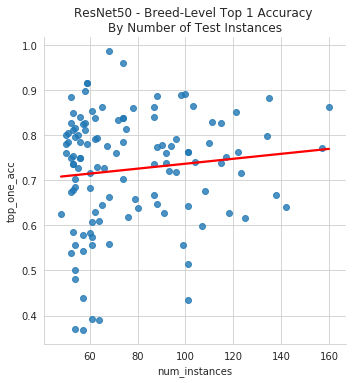

In [62]:
sns.set_style("whitegrid")
sns.lmplot(x = "num_instances", y = "top_one_acc", 
           data = acc_by_breed, ci = None, line_kws = {"color":"red"})
ax = plt.gca()
ax.set_title("ResNet50 - Breed-Level Top 1 Accuracy \nBy Number of Test Instances")

Text(0.5, 1, 'ResNet50 - Breed-Level Top 5 Accuracy \nBy Number of Test Instances')

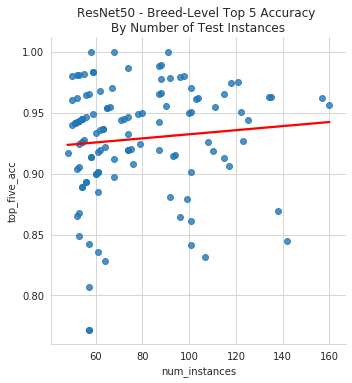

In [63]:
sns.set_style("whitegrid")
sns.lmplot(x = "num_instances", y = "top_five_acc", 
           data = acc_by_breed, ci = None, line_kws = {"color":"red"})
ax = plt.gca()
ax.set_title("ResNet50 - Breed-Level Top 5 Accuracy \nBy Number of Test Instances")

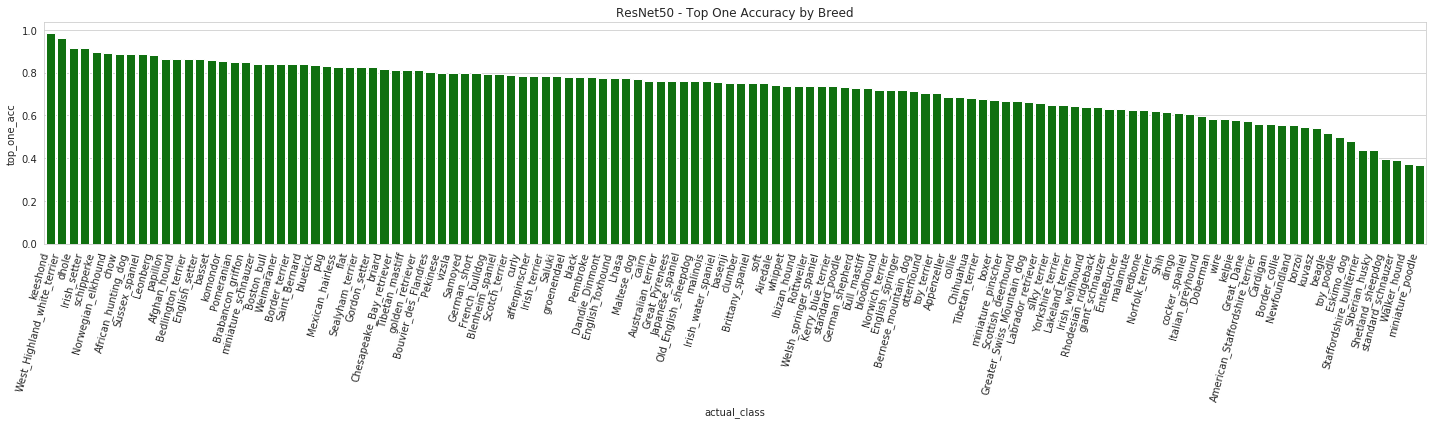

In [64]:
fig, ax = plt.subplots(figsize = (20,6))
sns.set_style("whitegrid")
order = acc_by_breed["top_one_acc"].sort_values(ascending = False).index.tolist()
acc_plot = sns.barplot(x = "actual_class", 
            y = "top_one_acc", 
            order = order,
            color = "green",
            ci = None,
            ax = ax,
            n_boot = None,
            data = test_df)
acc_plot.set_xticklabels(acc_plot.get_xticklabels(),
                         rotation = 75,
                         ha= 'right'
                        )
plt.title("ResNet50 - Top One Accuracy by Breed")
plt.tight_layout()

Quick Top-1 Accuracy Summary

- Only five percent of dog breeds had top-1 accuracy below 50 percent.
- Nearly 30% of breeds had top-1 accuracy between 50 and 70 percent.
- Just over 60% of breeds had top-1 accuracy between 70 and 90 percent.

In [66]:
pd.cut(acc_by_breed.top_one_acc, bins = np.linspace(0,1,11), 
       right = False, include_lowest = True).value_counts(normalize = True).sort_index()

[0.0, 0.1)    0.000000
[0.1, 0.2)    0.000000
[0.2, 0.3)    0.000000
[0.3, 0.4)    0.033333
[0.4, 0.5)    0.025000
[0.5, 0.6)    0.108333
[0.6, 0.7)    0.183333
[0.7, 0.8)    0.350000
[0.8, 0.9)    0.266667
[0.9, 1.0)    0.033333
Name: top_one_acc, dtype: float64

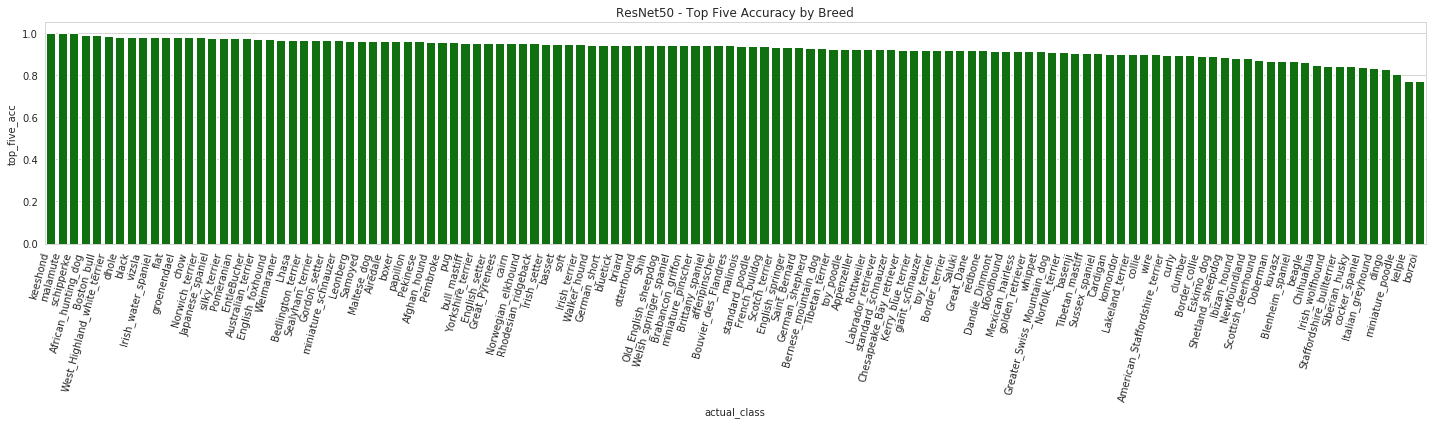

In [65]:
fig, ax = plt.subplots(figsize = (20,6))
sns.set_style("whitegrid")
order = acc_by_breed["top_five_acc"].sort_values(ascending = False).index.tolist()
acc_plot = sns.barplot(x = "actual_class", 
            y = "top_five_acc", 
            order = order,
            color = "green",
            ci = None,
            ax = ax,
            n_boot = None,
            data = test_df)
acc_plot.set_xticklabels(acc_plot.get_xticklabels(),
                         rotation = 75,
                         ha= 'right'
                        )
plt.title("ResNet50 - Top Five Accuracy by Breed")
plt.tight_layout()

Quick Top 5 Accuracy Summary

- 80 percent of breeds had top-5 accuracy at or above 90%
- the remaining 20 percent of breeds had top-5 accuracy between 80% and 90%
- to be really specific about it, only two percent of breeds had top-5 accurcy below 70%

In [67]:
pd.cut(acc_by_breed.top_five_acc, bins = np.linspace(0,1,11), 
       right = False, include_lowest = True).value_counts(normalize = True).sort_index()

[0.0, 0.1)    0.000000
[0.1, 0.2)    0.000000
[0.2, 0.3)    0.000000
[0.3, 0.4)    0.000000
[0.4, 0.5)    0.000000
[0.5, 0.6)    0.000000
[0.6, 0.7)    0.000000
[0.7, 0.8)    0.017094
[0.8, 0.9)    0.179487
[0.9, 1.0)    0.803419
Name: top_five_acc, dtype: float64

## 6. Train, Deploy, Inference: GoogLeNet

In [28]:
estimator = PyTorch(entry_point = "train.py",
                    source_dir = "sourceTransferLearn",
                    role = role,
                    framework_version = "1.5.0",
                    train_instance_count = 1, 
                    train_instance_type = "ml.p2.xlarge",
                    output_path = output_path,
                    sagemaker_session = sagemaker_session, 
                    hyperparameters = {
                        "epochs": 20,
                        "batch-size": 128,
                        "model_name":"googlenet",
                        "hidden_units":512,
                        "dropout":0.33
                    })

In [29]:
%%time
estimator.fit({"train":train_data_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-06-24 19:02:25 Starting - Starting the training job...
2020-06-24 19:02:27 Starting - Launching requested ML instances.........
2020-06-24 19:03:59 Starting - Preparing the instances for training......
2020-06-24 19:05:25 Downloading - Downloading input data............
2020-06-24 19:07:16 Training - Downloading the training image......
2020-06-24 19:08:20 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-24 19:08:21,180 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-24 19:08:21,208 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-24 19:08:22,636 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-24 19:08:22,908 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.p

Epoch 15, Loss 1.1022, Accuracy: 67.12%
Epoch 16, Loss 1.0874, Accuracy: 67.48%
Epoch 17, Loss 1.0822, Accuracy: 67.33%
Epoch 18, Loss 1.0722, Accuracy: 67.77%
Epoch 19, Loss 1.0680, Accuracy: 67.21%
Epoch 20, Loss 1.0371, Accuracy: 68.28%
[2020-06-24 19:38:25.309 algo-1:43 INFO utils.py:25] The end of training job file will not be written for jobs running under SageMaker.
2020-06-24 19:38:25,839 sagemaker-containers INFO     Reporting training SUCCESS

2020-06-24 19:38:46 Uploading - Uploading generated training model
2020-06-24 19:38:46 Completed - Training job completed
Training seconds: 2001
Billable seconds: 2001
CPU times: user 5 s, sys: 160 ms, total: 5.16 s
Wall time: 36min 36s


In [30]:
estimator.model_data

's3://sagemaker-dogproj/model-output/pytorch-training-2020-06-24-19-02-25-039/output/model.tar.gz'

In [38]:
goog_training_job = "pytorch-training-2020-06-24-19-02-25-039"
goog_model_data = f"{output_path}/{goog_training_job}/output/model.tar.gz"
goog_model_data

's3://sagemaker-dogproj/model-output/pytorch-training-2020-06-24-19-02-25-039/output/model.tar.gz'

In [35]:
model = PyTorchModel(model_data = estimator.model_data, 
                     role = role, 
                     framework_version = "1.5.0",
                     entry_point = "predict.py", 
                     source_dir = "sourceTransferLearn")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


GoogLeNet is the only one of these that I feel semi comfortable trying to deploy on an `ml.t2.medium`...

In [36]:
%%time
predictor = model.deploy(initial_instance_count = 1, instance_type = "ml.t2.medium")

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


------------------!CPU times: user 2.26 s, sys: 212 ms, total: 2.48 s
Wall time: 9min 4s


In [39]:
image_transforms = {
    "train":
    transforms.Compose([
        transforms.RandomResizedCrop(size = 256, scale = (0.85, 1.0)),
        transforms.RandomRotation(degrees = 20),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test":
    transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
test_img_folder = datasets.ImageFolder(root = data_dir / "test",
                                   transform = image_transforms["test"])
test_data_loader = DataLoader(dataset = test_img_folder, batch_size = 3, shuffle = True)
class_to_idx = test_data_loader.dataset.class_to_idx
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}

In [40]:
test_acc_objs = []

for feat_batch, label_batch in tqdm(test_data_loader):
    label_batch = label_batch.numpy()
    feat_batch = feat_batch.numpy()
    output = predictor.predict(feat_batch)
    classes = output[0]
    probs = output[1]
    for i, preds in enumerate(classes):
        act_label = label_batch[i]
        acc_dict = {}
        acc_dict["predicted_labels"] = preds.tolist()
        acc_dict["predicted_classes"] = [idx_to_class[k] for k in preds.tolist()]
        acc_dict["predicted_probs"] = probs[i].tolist()
        acc_dict["actual_label"] = act_label
        acc_dict["actual_class"] = idx_to_class[act_label]
        acc_dict["top_one_acc"] = int(act_label == preds[0])
        acc_dict["top_five_acc"] = int(np.any(act_label == preds))
        test_acc_objs.append(acc_dict)

test_df = pd.DataFrame(data = test_acc_objs)  



  0%|          | 0/3083 [00:00<?, ?it/s]

  0%|          | 1/3083 [00:00<39:56,  1.29it/s]

  0%|          | 2/3083 [00:01<34:46,  1.48it/s]

  0%|          | 3/3083 [00:01<31:18,  1.64it/s]

  0%|          | 4/3083 [00:02<28:27,  1.80it/s]

  0%|          | 5/3083 [00:02<27:06,  1.89it/s]

  0%|          | 6/3083 [00:02<25:18,  2.03it/s]

  0%|          | 7/3083 [00:03<23:56,  2.14it/s]

  0%|          | 8/3083 [00:03<22:55,  2.24it/s]

  0%|          | 9/3083 [00:04<22:35,  2.27it/s]

  0%|          | 10/3083 [00:04<21:58,  2.33it/s]

  0%|          | 11/3083 [00:05<21:37,  2.37it/s]

  0%|          | 12/3083 [00:05<21:23,  2.39it/s]

  0%|          | 13/3083 [00:05<21:20,  2.40it/s]

  0%|          | 14/3083 [00:06<21:44,  2.35it/s]

  0%|          | 15/3083 [00:06<21:42,  2.36it/s]

  1%|          | 16/3083 [00:07<21:20,  2.40it/s]

  1%|          | 17/3083 [00:07<21:19,  2.40it/s]

  1%|          | 18/3083 [00:07<21:02,  2.43it/s]

  1%|          | 19/3083 [00:08<20:58,  2.43it/

  5%|▍         | 143/3083 [00:59<19:34,  2.50it/s]

  5%|▍         | 144/3083 [00:59<19:39,  2.49it/s]

  5%|▍         | 145/3083 [01:00<19:35,  2.50it/s]

  5%|▍         | 146/3083 [01:00<19:40,  2.49it/s]

  5%|▍         | 147/3083 [01:00<19:33,  2.50it/s]

  5%|▍         | 148/3083 [01:01<19:37,  2.49it/s]

  5%|▍         | 149/3083 [01:01<19:44,  2.48it/s]

  5%|▍         | 150/3083 [01:02<19:49,  2.47it/s]

  5%|▍         | 151/3083 [01:02<19:41,  2.48it/s]

  5%|▍         | 152/3083 [01:02<19:44,  2.48it/s]

  5%|▍         | 153/3083 [01:03<19:42,  2.48it/s]

  5%|▍         | 154/3083 [01:03<19:36,  2.49it/s]

  5%|▌         | 155/3083 [01:04<19:43,  2.47it/s]

  5%|▌         | 156/3083 [01:04<19:46,  2.47it/s]

  5%|▌         | 157/3083 [01:04<19:43,  2.47it/s]

  5%|▌         | 158/3083 [01:05<19:41,  2.47it/s]

  5%|▌         | 159/3083 [01:05<19:36,  2.49it/s]

  5%|▌         | 160/3083 [01:06<19:36,  2.48it/s]

  5%|▌         | 161/3083 [01:06<19:51,  2.45it/s]

  5%|▌      

  9%|▉         | 284/3083 [02:14<56:04,  1.20s/it]

  9%|▉         | 285/3083 [02:16<57:13,  1.23s/it]

  9%|▉         | 286/3083 [02:17<56:25,  1.21s/it]

  9%|▉         | 287/3083 [02:18<57:43,  1.24s/it]

  9%|▉         | 288/3083 [02:19<1:00:47,  1.31s/it]

  9%|▉         | 289/3083 [02:21<57:33,  1.24s/it]  

  9%|▉         | 290/3083 [02:22<56:53,  1.22s/it]

  9%|▉         | 291/3083 [02:23<56:05,  1.21s/it]

  9%|▉         | 292/3083 [02:24<56:50,  1.22s/it]

 10%|▉         | 293/3083 [02:25<55:00,  1.18s/it]

 10%|▉         | 294/3083 [02:26<54:11,  1.17s/it]

 10%|▉         | 295/3083 [02:28<54:54,  1.18s/it]

 10%|▉         | 296/3083 [02:29<53:53,  1.16s/it]

 10%|▉         | 297/3083 [02:30<54:31,  1.17s/it]

 10%|▉         | 298/3083 [02:31<54:02,  1.16s/it]

 10%|▉         | 299/3083 [02:32<55:23,  1.19s/it]

 10%|▉         | 300/3083 [02:33<53:32,  1.15s/it]

 10%|▉         | 301/3083 [02:35<55:52,  1.21s/it]

 10%|▉         | 302/3083 [02:36<55:05,  1.19s/it]

 10%|▉  

 14%|█▍        | 424/3083 [04:59<17:40,  2.51it/s]

 14%|█▍        | 425/3083 [04:59<17:34,  2.52it/s]

 14%|█▍        | 426/3083 [04:59<17:38,  2.51it/s]

 14%|█▍        | 427/3083 [05:00<17:24,  2.54it/s]

 14%|█▍        | 428/3083 [05:00<17:27,  2.53it/s]

 14%|█▍        | 429/3083 [05:01<17:32,  2.52it/s]

 14%|█▍        | 430/3083 [05:01<17:26,  2.54it/s]

 14%|█▍        | 431/3083 [05:01<17:21,  2.55it/s]

 14%|█▍        | 432/3083 [05:02<17:25,  2.53it/s]

 14%|█▍        | 433/3083 [05:02<17:17,  2.56it/s]

 14%|█▍        | 434/3083 [05:03<17:20,  2.55it/s]

 14%|█▍        | 435/3083 [05:03<17:14,  2.56it/s]

 14%|█▍        | 436/3083 [05:03<17:10,  2.57it/s]

 14%|█▍        | 437/3083 [05:04<17:15,  2.55it/s]

 14%|█▍        | 438/3083 [05:04<17:10,  2.57it/s]

 14%|█▍        | 439/3083 [05:05<17:03,  2.58it/s]

 14%|█▍        | 440/3083 [05:05<17:21,  2.54it/s]

 14%|█▍        | 441/3083 [05:05<17:12,  2.56it/s]

 14%|█▍        | 442/3083 [05:06<17:22,  2.53it/s]

 14%|█▍     

 18%|█▊        | 565/3083 [05:54<16:36,  2.53it/s]

 18%|█▊        | 566/3083 [05:55<16:43,  2.51it/s]

 18%|█▊        | 567/3083 [05:55<17:03,  2.46it/s]

 18%|█▊        | 568/3083 [05:56<17:06,  2.45it/s]

 18%|█▊        | 569/3083 [05:56<16:50,  2.49it/s]

 18%|█▊        | 570/3083 [05:57<17:04,  2.45it/s]

 19%|█▊        | 571/3083 [05:57<17:05,  2.45it/s]

 19%|█▊        | 572/3083 [05:57<17:13,  2.43it/s]

 19%|█▊        | 573/3083 [05:58<17:05,  2.45it/s]

 19%|█▊        | 574/3083 [05:58<17:22,  2.41it/s]

 19%|█▊        | 575/3083 [05:59<17:30,  2.39it/s]

 19%|█▊        | 576/3083 [05:59<17:58,  2.33it/s]

 19%|█▊        | 577/3083 [06:00<19:00,  2.20it/s]

 19%|█▊        | 578/3083 [06:00<18:51,  2.21it/s]

 19%|█▉        | 579/3083 [06:00<18:34,  2.25it/s]

 19%|█▉        | 580/3083 [06:01<18:27,  2.26it/s]

 19%|█▉        | 581/3083 [06:01<18:15,  2.28it/s]

 19%|█▉        | 582/3083 [06:02<19:41,  2.12it/s]

 19%|█▉        | 583/3083 [06:02<19:32,  2.13it/s]

 19%|█▉     

 23%|██▎       | 706/3083 [08:28<43:44,  1.10s/it]

 23%|██▎       | 707/3083 [08:29<47:10,  1.19s/it]

 23%|██▎       | 708/3083 [08:30<44:35,  1.13s/it]

 23%|██▎       | 709/3083 [08:32<46:22,  1.17s/it]

 23%|██▎       | 710/3083 [08:33<44:33,  1.13s/it]

 23%|██▎       | 711/3083 [08:34<46:48,  1.18s/it]

 23%|██▎       | 712/3083 [08:35<45:10,  1.14s/it]

 23%|██▎       | 713/3083 [08:36<46:34,  1.18s/it]

 23%|██▎       | 714/3083 [08:37<44:54,  1.14s/it]

 23%|██▎       | 715/3083 [08:39<47:21,  1.20s/it]

 23%|██▎       | 716/3083 [08:40<45:36,  1.16s/it]

 23%|██▎       | 717/3083 [08:41<45:55,  1.16s/it]

 23%|██▎       | 718/3083 [08:42<44:33,  1.13s/it]

 23%|██▎       | 719/3083 [08:43<47:07,  1.20s/it]

 23%|██▎       | 720/3083 [08:44<44:46,  1.14s/it]

 23%|██▎       | 721/3083 [08:46<49:14,  1.25s/it]

 23%|██▎       | 722/3083 [08:47<46:39,  1.19s/it]

 23%|██▎       | 723/3083 [08:48<47:51,  1.22s/it]

 23%|██▎       | 724/3083 [08:49<50:07,  1.27s/it]

 24%|██▎    

 27%|██▋       | 847/3083 [10:20<14:35,  2.56it/s]

 28%|██▊       | 848/3083 [10:20<14:25,  2.58it/s]

 28%|██▊       | 849/3083 [10:21<14:30,  2.57it/s]

 28%|██▊       | 850/3083 [10:21<14:21,  2.59it/s]

 28%|██▊       | 851/3083 [10:21<14:35,  2.55it/s]

 28%|██▊       | 852/3083 [10:22<14:28,  2.57it/s]

 28%|██▊       | 853/3083 [10:22<14:35,  2.55it/s]

 28%|██▊       | 854/3083 [10:23<14:31,  2.56it/s]

 28%|██▊       | 855/3083 [10:23<14:29,  2.56it/s]

 28%|██▊       | 856/3083 [10:23<14:22,  2.58it/s]

 28%|██▊       | 857/3083 [10:24<14:23,  2.58it/s]

 28%|██▊       | 858/3083 [10:24<14:13,  2.61it/s]

 28%|██▊       | 859/3083 [10:24<14:25,  2.57it/s]

 28%|██▊       | 860/3083 [10:25<14:15,  2.60it/s]

 28%|██▊       | 861/3083 [10:25<14:31,  2.55it/s]

 28%|██▊       | 862/3083 [10:26<14:32,  2.55it/s]

 28%|██▊       | 863/3083 [10:26<14:30,  2.55it/s]

 28%|██▊       | 864/3083 [10:26<14:24,  2.57it/s]

 28%|██▊       | 865/3083 [10:27<14:44,  2.51it/s]

 28%|██▊    

 32%|███▏      | 988/3083 [11:33<42:03,  1.20s/it]

 32%|███▏      | 989/3083 [11:34<40:12,  1.15s/it]

 32%|███▏      | 990/3083 [11:35<40:48,  1.17s/it]

 32%|███▏      | 991/3083 [11:36<38:17,  1.10s/it]

 32%|███▏      | 992/3083 [11:37<37:09,  1.07s/it]

 32%|███▏      | 993/3083 [11:38<39:52,  1.14s/it]

 32%|███▏      | 994/3083 [11:39<38:29,  1.11s/it]

 32%|███▏      | 995/3083 [11:40<39:52,  1.15s/it]

 32%|███▏      | 996/3083 [11:41<38:06,  1.10s/it]

 32%|███▏      | 997/3083 [11:43<39:57,  1.15s/it]

 32%|███▏      | 998/3083 [11:44<39:08,  1.13s/it]

 32%|███▏      | 999/3083 [11:45<40:05,  1.15s/it]

 32%|███▏      | 1000/3083 [11:46<41:15,  1.19s/it]

 32%|███▏      | 1001/3083 [11:47<41:56,  1.21s/it]

 33%|███▎      | 1002/3083 [11:49<40:27,  1.17s/it]

 33%|███▎      | 1003/3083 [11:50<41:39,  1.20s/it]

 33%|███▎      | 1004/3083 [11:51<39:53,  1.15s/it]

 33%|███▎      | 1005/3083 [11:52<40:33,  1.17s/it]

 33%|███▎      | 1006/3083 [11:54<44:13,  1.28s/it]

 33%|

 37%|███▋      | 1127/3083 [14:16<37:14,  1.14s/it]

 37%|███▋      | 1128/3083 [14:17<35:53,  1.10s/it]

 37%|███▋      | 1129/3083 [14:18<37:24,  1.15s/it]

 37%|███▋      | 1130/3083 [14:19<35:45,  1.10s/it]

 37%|███▋      | 1131/3083 [14:21<37:23,  1.15s/it]

 37%|███▋      | 1132/3083 [14:22<36:26,  1.12s/it]

 37%|███▋      | 1133/3083 [14:23<36:42,  1.13s/it]

 37%|███▋      | 1134/3083 [14:24<36:05,  1.11s/it]

 37%|███▋      | 1135/3083 [14:25<35:46,  1.10s/it]

 37%|███▋      | 1136/3083 [14:26<37:57,  1.17s/it]

 37%|███▋      | 1137/3083 [14:28<42:42,  1.32s/it]

 37%|███▋      | 1138/3083 [14:29<40:07,  1.24s/it]

 37%|███▋      | 1139/3083 [14:30<39:12,  1.21s/it]

 37%|███▋      | 1140/3083 [14:31<37:47,  1.17s/it]

 37%|███▋      | 1141/3083 [14:32<36:54,  1.14s/it]

 37%|███▋      | 1142/3083 [14:34<37:00,  1.14s/it]

 37%|███▋      | 1143/3083 [14:35<36:42,  1.14s/it]

 37%|███▋      | 1144/3083 [14:36<37:07,  1.15s/it]

 37%|███▋      | 1145/3083 [14:37<35:42,  1.11

 41%|████      | 1265/3083 [15:35<11:51,  2.56it/s]

 41%|████      | 1266/3083 [15:35<11:54,  2.54it/s]

 41%|████      | 1267/3083 [15:36<11:53,  2.54it/s]

 41%|████      | 1268/3083 [15:36<11:56,  2.53it/s]

 41%|████      | 1269/3083 [15:37<11:55,  2.53it/s]

 41%|████      | 1270/3083 [15:37<11:55,  2.54it/s]

 41%|████      | 1271/3083 [15:37<11:51,  2.55it/s]

 41%|████▏     | 1272/3083 [15:38<11:50,  2.55it/s]

 41%|████▏     | 1273/3083 [15:38<11:54,  2.53it/s]

 41%|████▏     | 1274/3083 [15:39<11:45,  2.56it/s]

 41%|████▏     | 1275/3083 [15:39<11:55,  2.53it/s]

 41%|████▏     | 1276/3083 [15:39<11:49,  2.55it/s]

 41%|████▏     | 1277/3083 [15:40<11:46,  2.56it/s]

 41%|████▏     | 1278/3083 [15:40<11:48,  2.55it/s]

 41%|████▏     | 1279/3083 [15:40<11:54,  2.53it/s]

 42%|████▏     | 1280/3083 [15:41<11:53,  2.53it/s]

 42%|████▏     | 1281/3083 [15:41<11:54,  2.52it/s]

 42%|████▏     | 1282/3083 [15:42<11:51,  2.53it/s]

 42%|████▏     | 1283/3083 [15:42<11:58,  2.51

 46%|████▌     | 1403/3083 [17:14<33:11,  1.19s/it]

 46%|████▌     | 1404/3083 [17:15<32:26,  1.16s/it]

 46%|████▌     | 1405/3083 [17:16<33:28,  1.20s/it]

 46%|████▌     | 1406/3083 [17:17<32:18,  1.16s/it]

 46%|████▌     | 1407/3083 [17:18<32:31,  1.16s/it]

 46%|████▌     | 1408/3083 [17:19<31:19,  1.12s/it]

 46%|████▌     | 1409/3083 [17:20<32:12,  1.15s/it]

 46%|████▌     | 1410/3083 [17:22<34:29,  1.24s/it]

 46%|████▌     | 1411/3083 [17:23<34:39,  1.24s/it]

 46%|████▌     | 1412/3083 [17:24<32:41,  1.17s/it]

 46%|████▌     | 1413/3083 [17:25<34:06,  1.23s/it]

 46%|████▌     | 1414/3083 [17:27<32:51,  1.18s/it]

 46%|████▌     | 1415/3083 [17:28<34:13,  1.23s/it]

 46%|████▌     | 1416/3083 [17:29<32:55,  1.18s/it]

 46%|████▌     | 1417/3083 [17:30<33:52,  1.22s/it]

 46%|████▌     | 1418/3083 [17:32<34:43,  1.25s/it]

 46%|████▌     | 1419/3083 [17:33<34:54,  1.26s/it]

 46%|████▌     | 1420/3083 [17:34<33:13,  1.20s/it]

 46%|████▌     | 1421/3083 [17:35<34:00,  1.23

 50%|████▉     | 1541/3083 [19:57<10:53,  2.36it/s]

 50%|█████     | 1542/3083 [19:57<10:41,  2.40it/s]

 50%|█████     | 1543/3083 [19:58<10:28,  2.45it/s]

 50%|█████     | 1544/3083 [19:58<10:34,  2.43it/s]

 50%|█████     | 1545/3083 [19:58<10:25,  2.46it/s]

 50%|█████     | 1546/3083 [19:59<10:16,  2.49it/s]

 50%|█████     | 1547/3083 [19:59<10:09,  2.52it/s]

 50%|█████     | 1548/3083 [20:00<10:09,  2.52it/s]

 50%|█████     | 1549/3083 [20:00<10:07,  2.53it/s]

 50%|█████     | 1550/3083 [20:00<10:04,  2.54it/s]

 50%|█████     | 1551/3083 [20:01<09:55,  2.57it/s]

 50%|█████     | 1552/3083 [20:01<09:56,  2.57it/s]

 50%|█████     | 1553/3083 [20:02<10:00,  2.55it/s]

 50%|█████     | 1554/3083 [20:02<09:59,  2.55it/s]

 50%|█████     | 1555/3083 [20:02<09:59,  2.55it/s]

 50%|█████     | 1556/3083 [20:03<10:02,  2.53it/s]

 51%|█████     | 1557/3083 [20:03<09:53,  2.57it/s]

 51%|█████     | 1558/3083 [20:04<09:59,  2.54it/s]

 51%|█████     | 1559/3083 [20:04<10:02,  2.53

 54%|█████▍    | 1679/3083 [20:51<09:12,  2.54it/s]

 54%|█████▍    | 1680/3083 [20:52<09:07,  2.56it/s]

 55%|█████▍    | 1681/3083 [20:52<09:10,  2.55it/s]

 55%|█████▍    | 1682/3083 [20:52<09:08,  2.55it/s]

 55%|█████▍    | 1683/3083 [20:53<09:09,  2.55it/s]

 55%|█████▍    | 1684/3083 [20:53<09:11,  2.54it/s]

 55%|█████▍    | 1685/3083 [20:54<09:23,  2.48it/s]

 55%|█████▍    | 1686/3083 [20:54<09:20,  2.49it/s]

 55%|█████▍    | 1687/3083 [20:54<09:17,  2.50it/s]

 55%|█████▍    | 1688/3083 [20:55<09:33,  2.43it/s]

 55%|█████▍    | 1689/3083 [20:55<09:23,  2.47it/s]

 55%|█████▍    | 1690/3083 [20:56<09:16,  2.50it/s]

 55%|█████▍    | 1691/3083 [20:56<09:16,  2.50it/s]

 55%|█████▍    | 1692/3083 [20:56<09:15,  2.50it/s]

 55%|█████▍    | 1693/3083 [20:57<09:26,  2.45it/s]

 55%|█████▍    | 1694/3083 [20:57<09:21,  2.47it/s]

 55%|█████▍    | 1695/3083 [20:58<09:20,  2.47it/s]

 55%|█████▌    | 1696/3083 [20:58<09:18,  2.48it/s]

 55%|█████▌    | 1697/3083 [20:58<09:28,  2.44

 59%|█████▉    | 1817/3083 [23:13<25:32,  1.21s/it]

 59%|█████▉    | 1818/3083 [23:14<24:12,  1.15s/it]

 59%|█████▉    | 1819/3083 [23:15<23:57,  1.14s/it]

 59%|█████▉    | 1820/3083 [23:16<23:35,  1.12s/it]

 59%|█████▉    | 1821/3083 [23:17<23:35,  1.12s/it]

 59%|█████▉    | 1822/3083 [23:18<23:33,  1.12s/it]

 59%|█████▉    | 1823/3083 [23:19<22:56,  1.09s/it]

 59%|█████▉    | 1824/3083 [23:21<24:08,  1.15s/it]

 59%|█████▉    | 1825/3083 [23:22<23:33,  1.12s/it]

 59%|█████▉    | 1826/3083 [23:23<24:17,  1.16s/it]

 59%|█████▉    | 1827/3083 [23:24<23:17,  1.11s/it]

 59%|█████▉    | 1828/3083 [23:25<24:28,  1.17s/it]

 59%|█████▉    | 1829/3083 [23:26<23:46,  1.14s/it]

 59%|█████▉    | 1830/3083 [23:28<24:58,  1.20s/it]

 59%|█████▉    | 1831/3083 [23:29<24:05,  1.15s/it]

 59%|█████▉    | 1832/3083 [23:30<24:53,  1.19s/it]

 59%|█████▉    | 1833/3083 [23:31<23:47,  1.14s/it]

 59%|█████▉    | 1834/3083 [23:32<24:20,  1.17s/it]

 60%|█████▉    | 1835/3083 [23:33<23:35,  1.13

 63%|██████▎   | 1955/3083 [25:14<07:23,  2.54it/s]

 63%|██████▎   | 1956/3083 [25:14<07:24,  2.54it/s]

 63%|██████▎   | 1957/3083 [25:14<07:18,  2.57it/s]

 64%|██████▎   | 1958/3083 [25:15<07:28,  2.51it/s]

 64%|██████▎   | 1959/3083 [25:15<07:28,  2.51it/s]

 64%|██████▎   | 1960/3083 [25:16<07:27,  2.51it/s]

 64%|██████▎   | 1961/3083 [25:16<07:23,  2.53it/s]

 64%|██████▎   | 1962/3083 [25:16<07:30,  2.49it/s]

 64%|██████▎   | 1963/3083 [25:17<07:30,  2.49it/s]

 64%|██████▎   | 1964/3083 [25:17<07:34,  2.46it/s]

 64%|██████▎   | 1965/3083 [25:18<07:26,  2.50it/s]

 64%|██████▍   | 1966/3083 [25:18<07:27,  2.50it/s]

 64%|██████▍   | 1967/3083 [25:18<07:25,  2.50it/s]

 64%|██████▍   | 1968/3083 [25:19<07:24,  2.51it/s]

 64%|██████▍   | 1969/3083 [25:19<07:21,  2.53it/s]

 64%|██████▍   | 1970/3083 [25:20<07:26,  2.49it/s]

 64%|██████▍   | 1971/3083 [25:20<07:20,  2.52it/s]

 64%|██████▍   | 1972/3083 [25:20<07:24,  2.50it/s]

 64%|██████▍   | 1973/3083 [25:21<07:24,  2.50

 68%|██████▊   | 2093/3083 [26:15<18:29,  1.12s/it]

 68%|██████▊   | 2094/3083 [26:16<18:07,  1.10s/it]

 68%|██████▊   | 2095/3083 [26:17<18:48,  1.14s/it]

 68%|██████▊   | 2096/3083 [26:18<18:14,  1.11s/it]

 68%|██████▊   | 2097/3083 [26:19<19:16,  1.17s/it]

 68%|██████▊   | 2098/3083 [26:20<18:41,  1.14s/it]

 68%|██████▊   | 2099/3083 [26:22<19:24,  1.18s/it]

 68%|██████▊   | 2100/3083 [26:23<18:27,  1.13s/it]

 68%|██████▊   | 2101/3083 [26:24<19:12,  1.17s/it]

 68%|██████▊   | 2102/3083 [26:25<18:11,  1.11s/it]

 68%|██████▊   | 2103/3083 [26:26<19:07,  1.17s/it]

 68%|██████▊   | 2104/3083 [26:27<18:36,  1.14s/it]

 68%|██████▊   | 2105/3083 [26:28<19:26,  1.19s/it]

 68%|██████▊   | 2106/3083 [26:30<19:17,  1.19s/it]

 68%|██████▊   | 2107/3083 [26:31<19:40,  1.21s/it]

 68%|██████▊   | 2108/3083 [26:32<18:48,  1.16s/it]

 68%|██████▊   | 2109/3083 [26:33<19:19,  1.19s/it]

 68%|██████▊   | 2110/3083 [26:34<18:41,  1.15s/it]

 68%|██████▊   | 2111/3083 [26:36<19:13,  1.19

 72%|███████▏  | 2231/3083 [28:55<16:28,  1.16s/it]

 72%|███████▏  | 2232/3083 [28:56<16:53,  1.19s/it]

 72%|███████▏  | 2233/3083 [28:57<16:05,  1.14s/it]

 72%|███████▏  | 2234/3083 [28:59<16:52,  1.19s/it]

 72%|███████▏  | 2235/3083 [29:00<16:21,  1.16s/it]

 73%|███████▎  | 2236/3083 [29:01<16:23,  1.16s/it]

 73%|███████▎  | 2237/3083 [29:02<16:07,  1.14s/it]

 73%|███████▎  | 2238/3083 [29:03<16:29,  1.17s/it]

 73%|███████▎  | 2239/3083 [29:04<16:13,  1.15s/it]

 73%|███████▎  | 2240/3083 [29:05<16:32,  1.18s/it]

 73%|███████▎  | 2241/3083 [29:07<16:04,  1.15s/it]

 73%|███████▎  | 2242/3083 [29:08<16:24,  1.17s/it]

 73%|███████▎  | 2243/3083 [29:09<15:53,  1.14s/it]

 73%|███████▎  | 2244/3083 [29:10<16:19,  1.17s/it]

 73%|███████▎  | 2245/3083 [29:11<15:39,  1.12s/it]

 73%|███████▎  | 2246/3083 [29:12<15:32,  1.11s/it]

 73%|███████▎  | 2247/3083 [29:13<15:55,  1.14s/it]

 73%|███████▎  | 2248/3083 [29:14<15:19,  1.10s/it]

 73%|███████▎  | 2249/3083 [29:16<17:18,  1.24

 77%|███████▋  | 2369/3083 [30:28<04:42,  2.52it/s]

 77%|███████▋  | 2370/3083 [30:28<04:39,  2.56it/s]

 77%|███████▋  | 2371/3083 [30:29<04:43,  2.51it/s]

 77%|███████▋  | 2372/3083 [30:29<04:38,  2.56it/s]

 77%|███████▋  | 2373/3083 [30:29<04:41,  2.52it/s]

 77%|███████▋  | 2374/3083 [30:30<04:39,  2.54it/s]

 77%|███████▋  | 2375/3083 [30:30<04:38,  2.55it/s]

 77%|███████▋  | 2376/3083 [30:31<04:35,  2.56it/s]

 77%|███████▋  | 2377/3083 [30:31<04:41,  2.51it/s]

 77%|███████▋  | 2378/3083 [30:31<04:42,  2.50it/s]

 77%|███████▋  | 2379/3083 [30:32<04:40,  2.51it/s]

 77%|███████▋  | 2380/3083 [30:32<04:39,  2.51it/s]

 77%|███████▋  | 2381/3083 [30:33<04:38,  2.52it/s]

 77%|███████▋  | 2382/3083 [30:33<04:35,  2.55it/s]

 77%|███████▋  | 2383/3083 [30:33<04:37,  2.53it/s]

 77%|███████▋  | 2384/3083 [30:34<04:32,  2.56it/s]

 77%|███████▋  | 2385/3083 [30:34<04:35,  2.54it/s]

 77%|███████▋  | 2386/3083 [30:35<04:30,  2.57it/s]

 77%|███████▋  | 2387/3083 [30:35<04:33,  2.55

 81%|████████▏ | 2507/3083 [32:01<11:28,  1.20s/it]

 81%|████████▏ | 2508/3083 [32:02<10:55,  1.14s/it]

 81%|████████▏ | 2509/3083 [32:03<11:27,  1.20s/it]

 81%|████████▏ | 2510/3083 [32:04<10:53,  1.14s/it]

 81%|████████▏ | 2511/3083 [32:05<11:07,  1.17s/it]

 81%|████████▏ | 2512/3083 [32:06<10:34,  1.11s/it]

 82%|████████▏ | 2513/3083 [32:07<10:56,  1.15s/it]

 82%|████████▏ | 2514/3083 [32:09<10:43,  1.13s/it]

 82%|████████▏ | 2515/3083 [32:10<11:08,  1.18s/it]

 82%|████████▏ | 2516/3083 [32:11<10:44,  1.14s/it]

 82%|████████▏ | 2517/3083 [32:12<11:02,  1.17s/it]

 82%|████████▏ | 2518/3083 [32:13<10:41,  1.14s/it]

 82%|████████▏ | 2519/3083 [32:14<10:26,  1.11s/it]

 82%|████████▏ | 2520/3083 [32:15<10:26,  1.11s/it]

 82%|████████▏ | 2521/3083 [32:17<10:36,  1.13s/it]

 82%|████████▏ | 2522/3083 [32:18<10:49,  1.16s/it]

 82%|████████▏ | 2523/3083 [32:19<11:48,  1.26s/it]

 82%|████████▏ | 2524/3083 [32:20<11:07,  1.19s/it]

 82%|████████▏ | 2525/3083 [32:21<10:47,  1.16

 86%|████████▌ | 2645/3083 [34:46<09:43,  1.33s/it]

 86%|████████▌ | 2646/3083 [34:47<10:01,  1.38s/it]

 86%|████████▌ | 2647/3083 [34:49<09:31,  1.31s/it]

 86%|████████▌ | 2648/3083 [34:50<09:26,  1.30s/it]

 86%|████████▌ | 2649/3083 [34:51<09:01,  1.25s/it]

 86%|████████▌ | 2650/3083 [34:52<09:28,  1.31s/it]

 86%|████████▌ | 2651/3083 [34:53<08:38,  1.20s/it]

 86%|████████▌ | 2652/3083 [34:54<06:52,  1.04it/s]

 86%|████████▌ | 2653/3083 [34:54<05:40,  1.26it/s]

 86%|████████▌ | 2654/3083 [34:55<04:48,  1.49it/s]

 86%|████████▌ | 2655/3083 [34:55<04:09,  1.72it/s]

 86%|████████▌ | 2656/3083 [34:55<03:44,  1.90it/s]

 86%|████████▌ | 2657/3083 [34:56<03:26,  2.06it/s]

 86%|████████▌ | 2658/3083 [34:56<03:14,  2.18it/s]

 86%|████████▌ | 2659/3083 [34:57<03:05,  2.28it/s]

 86%|████████▋ | 2660/3083 [34:57<03:00,  2.34it/s]

 86%|████████▋ | 2661/3083 [34:57<02:53,  2.43it/s]

 86%|████████▋ | 2662/3083 [34:58<02:52,  2.44it/s]

 86%|████████▋ | 2663/3083 [34:58<02:47,  2.51

 90%|█████████ | 2783/3083 [35:45<01:57,  2.56it/s]

 90%|█████████ | 2784/3083 [35:45<01:55,  2.58it/s]

 90%|█████████ | 2785/3083 [35:46<01:55,  2.58it/s]

 90%|█████████ | 2786/3083 [35:46<01:57,  2.53it/s]

 90%|█████████ | 2787/3083 [35:47<01:56,  2.55it/s]

 90%|█████████ | 2788/3083 [35:47<01:56,  2.53it/s]

 90%|█████████ | 2789/3083 [35:47<01:56,  2.53it/s]

 90%|█████████ | 2790/3083 [35:48<01:55,  2.53it/s]

 91%|█████████ | 2791/3083 [35:48<01:56,  2.52it/s]

 91%|█████████ | 2792/3083 [35:49<01:53,  2.56it/s]

 91%|█████████ | 2793/3083 [35:49<01:54,  2.53it/s]

 91%|█████████ | 2794/3083 [35:49<01:53,  2.55it/s]

 91%|█████████ | 2795/3083 [35:50<01:52,  2.56it/s]

 91%|█████████ | 2796/3083 [35:50<01:51,  2.58it/s]

 91%|█████████ | 2797/3083 [35:51<01:50,  2.58it/s]

 91%|█████████ | 2798/3083 [35:51<01:50,  2.57it/s]

 91%|█████████ | 2799/3083 [35:51<01:51,  2.56it/s]

 91%|█████████ | 2800/3083 [35:52<01:50,  2.56it/s]

 91%|█████████ | 2801/3083 [35:52<01:51,  2.54

 95%|█████████▍| 2921/3083 [37:52<03:12,  1.19s/it]

 95%|█████████▍| 2922/3083 [37:53<03:02,  1.13s/it]

 95%|█████████▍| 2923/3083 [37:54<03:06,  1.17s/it]

 95%|█████████▍| 2924/3083 [37:55<03:00,  1.14s/it]

 95%|█████████▍| 2925/3083 [37:57<03:20,  1.27s/it]

 95%|█████████▍| 2926/3083 [37:58<03:06,  1.19s/it]

 95%|█████████▍| 2927/3083 [37:59<03:15,  1.25s/it]

 95%|█████████▍| 2928/3083 [38:00<03:02,  1.18s/it]

 95%|█████████▌| 2929/3083 [38:02<03:01,  1.18s/it]

 95%|█████████▌| 2930/3083 [38:03<03:00,  1.18s/it]

 95%|█████████▌| 2931/3083 [38:04<02:50,  1.12s/it]

 95%|█████████▌| 2932/3083 [38:05<02:53,  1.15s/it]

 95%|█████████▌| 2933/3083 [38:06<02:47,  1.12s/it]

 95%|█████████▌| 2934/3083 [38:07<02:50,  1.15s/it]

 95%|█████████▌| 2935/3083 [38:08<02:42,  1.10s/it]

 95%|█████████▌| 2936/3083 [38:10<02:51,  1.17s/it]

 95%|█████████▌| 2937/3083 [38:11<02:41,  1.11s/it]

 95%|█████████▌| 2938/3083 [38:12<02:45,  1.14s/it]

 95%|█████████▌| 2939/3083 [38:13<02:37,  1.09

 99%|█████████▉| 3059/3083 [40:06<00:09,  2.54it/s]

 99%|█████████▉| 3060/3083 [40:07<00:09,  2.52it/s]

 99%|█████████▉| 3061/3083 [40:07<00:08,  2.53it/s]

 99%|█████████▉| 3062/3083 [40:07<00:08,  2.50it/s]

 99%|█████████▉| 3063/3083 [40:08<00:07,  2.54it/s]

 99%|█████████▉| 3064/3083 [40:08<00:07,  2.54it/s]

 99%|█████████▉| 3065/3083 [40:09<00:07,  2.56it/s]

 99%|█████████▉| 3066/3083 [40:09<00:06,  2.53it/s]

 99%|█████████▉| 3067/3083 [40:09<00:06,  2.53it/s]

100%|█████████▉| 3068/3083 [40:10<00:06,  2.50it/s]

100%|█████████▉| 3069/3083 [40:10<00:05,  2.52it/s]

100%|█████████▉| 3070/3083 [40:11<00:05,  2.50it/s]

100%|█████████▉| 3071/3083 [40:11<00:04,  2.49it/s]

100%|█████████▉| 3072/3083 [40:11<00:04,  2.49it/s]

100%|█████████▉| 3073/3083 [40:12<00:04,  2.48it/s]

100%|█████████▉| 3074/3083 [40:12<00:03,  2.49it/s]

100%|█████████▉| 3075/3083 [40:13<00:03,  2.49it/s]

100%|█████████▉| 3076/3083 [40:13<00:02,  2.50it/s]

100%|█████████▉| 3077/3083 [40:13<00:02,  2.50

In [41]:
test_df.shape

(9249, 7)

In [42]:
test_df.head()

,predicted_labels,predicted_classes,predicted_probs,actual_label,actual_class,top_one_acc,top_five_acc
0,"[88.0, 63.0, 43.0, 8.0, 18.0]","[cocker_spaniel, Shih, Lhasa, Blenheim_spaniel...","[0.5675855875015259, 0.1626695841550827, 0.139...",44,Maltese_dog,0,0
1,"[0.0, 51.0, 99.0, 43.0, 38.0]","[Afghan_hound, Pekinese, komondor, Lhasa, Japa...","[0.8116347789764404, 0.03948618844151497, 0.02...",0,Afghan_hound,1,1
2,"[48.0, 101.0, 24.0, 64.0, 26.0]","[Norwegian_elkhound, malamute, Eskimo_dog, Sib...","[0.9775871634483337, 0.017112983390688896, 0.0...",48,Norwegian_elkhound,1,1
3,"[80.0, 27.0, 36.0, 118.0, 60.0]","[bluetick, German_short, Irish_wolfhound, whip...","[0.8649981021881104, 0.127833753824234, 0.0016...",80,bluetick,1,1
4,"[97.0, 43.0, 105.0, 101.0, 53.0]","[keeshond, Lhasa, miniature_schnauzer, malamut...","[0.9704267978668213, 0.00886542908847332, 0.00...",97,keeshond,1,1


In [43]:
sagemaker_session.delete_endpoint(predictor.endpoint)

In [44]:
n_test = len(test_df)
print(f"Top-One Accuracy was {test_df.top_one_acc.sum() / n_test:.2%}")
print(f"Top-Five Accuracy was {test_df.top_five_acc.sum() / n_test:.2%}")

Top-One Accuracy was 64.50%
Top-Five Accuracy was 89.22%


Well, that's significantly better in terms of generalization.

In [45]:
breed_agg = {"top_one_acc":"sum", 
             "top_five_acc":"sum", 
             "actual_label": "count"
            }
acc_by_breed = test_df.groupby(by = "actual_class").agg(breed_agg)
for col in ["top_one_acc", "top_five_acc"]:
    acc_by_breed[col] = acc_by_breed[col] / acc_by_breed.actual_label
acc_by_breed.rename(columns = {"actual_label":"num_instances"}, inplace = True)
acc_by_breed.describe()

,top_one_acc,top_five_acc,num_instances
count,120.000000,120.000000,120.000000
mean,0.637221,0.890459,77.075000
std,0.152557,0.059414,26.261824
min,0.166667,0.707071,48.000000
25%,0.541157,0.852093,56.000000
50%,0.647938,0.891258,65.500000
75%,0.749091,0.938125,94.500000
max,0.926471,1.000000,160.000000


**GoogLeNet**

The next two scatter plots put the accuracy rate in the context of the number of testing images we saw. We're not only seeing high within breed accuracy rates as a result of small denominators. As it turns out, there are only three breeds with top 1 accuracy below 30% and only two breeds. with top 1 accuracy below 75%

Text(0.5, 1, 'GoogLeNet - Breed-Level Top 1 Accuracy \nBy Number of Test Instances')

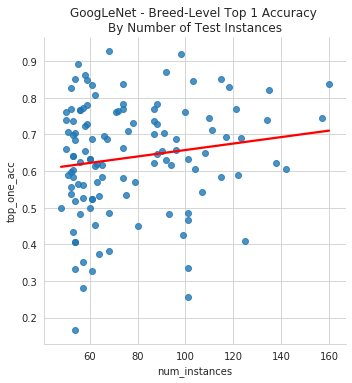

In [47]:
sns.set_style("whitegrid")
sns.lmplot(x = "num_instances", y = "top_one_acc", 
           data = acc_by_breed, ci = None, line_kws = {"color":"red"})
ax = plt.gca()
ax.set_title("GoogLeNet - Breed-Level Top 1 Accuracy \nBy Number of Test Instances")

Text(0.5, 1, 'GoogLeNet - Breed-Level Top 5 Accuracy \nBy Number of Test Instances')

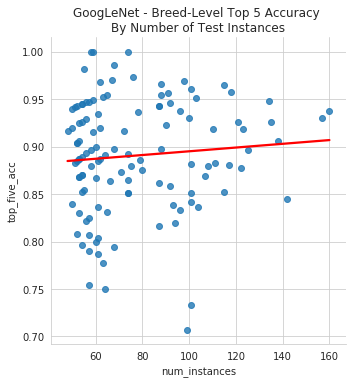

In [48]:
sns.set_style("whitegrid")
sns.lmplot(x = "num_instances", y = "top_five_acc", 
           data = acc_by_breed, ci = None, line_kws = {"color":"red"})
ax = plt.gca()
ax.set_title("GoogLeNet - Breed-Level Top 5 Accuracy \nBy Number of Test Instances")

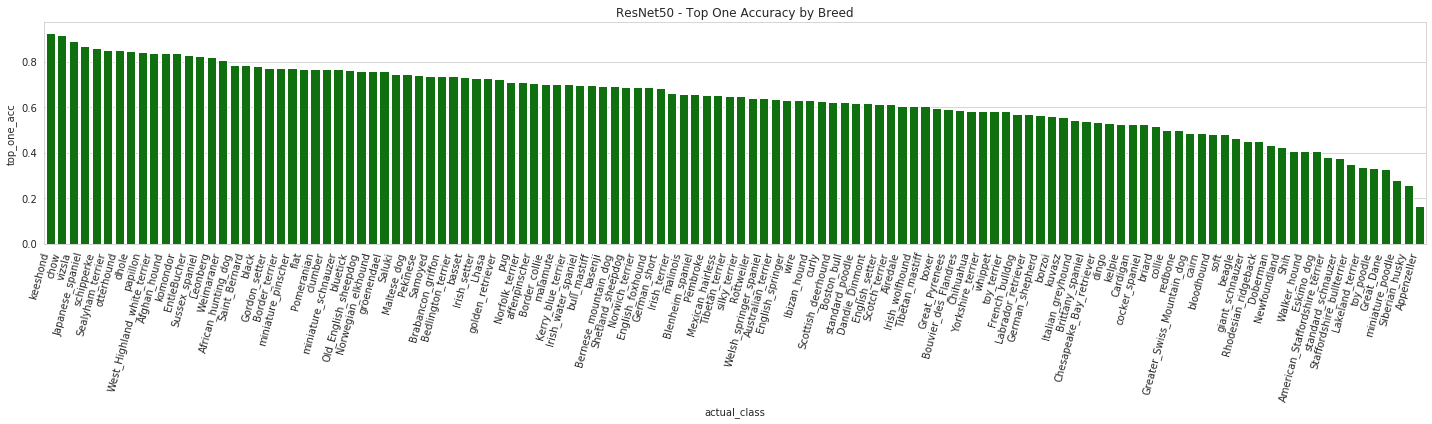

In [49]:
fig, ax = plt.subplots(figsize = (20,6))
sns.set_style("whitegrid")
order = acc_by_breed["top_one_acc"].sort_values(ascending = False).index.tolist()
acc_plot = sns.barplot(x = "actual_class", 
            y = "top_one_acc", 
            order = order,
            color = "green",
            ci = None,
            ax = ax,
            n_boot = None,
            data = test_df)
acc_plot.set_xticklabels(acc_plot.get_xticklabels(),
                         rotation = 75,
                         ha= 'right'
                        )
plt.title("ResNet50 - Top One Accuracy by Breed")
plt.tight_layout()

- Only two percent of breeds have top one accuracy below 30%: mini-poodle, siberian husky, and Appenzeller
- About one third of our breeds have top-1 accuracy between 30% and 60%
- About 50% of our breeds have top-1 accuracy rates between 60 and 80%.
- Just about 12% (let's call it one eighth) of the breeds have top-1 accuracy at or above 80%

In [50]:
pd.cut(acc_by_breed.top_one_acc, bins = np.linspace(0,1,11), 
       right = False, include_lowest = True).value_counts(normalize = True).sort_index()

[0.0, 0.1)    0.000000
[0.1, 0.2)    0.008333
[0.2, 0.3)    0.016667
[0.3, 0.4)    0.050000
[0.4, 0.5)    0.100000
[0.5, 0.6)    0.183333
[0.6, 0.7)    0.258333
[0.7, 0.8)    0.250000
[0.8, 0.9)    0.116667
[0.9, 1.0)    0.016667
Name: top_one_acc, dtype: float64

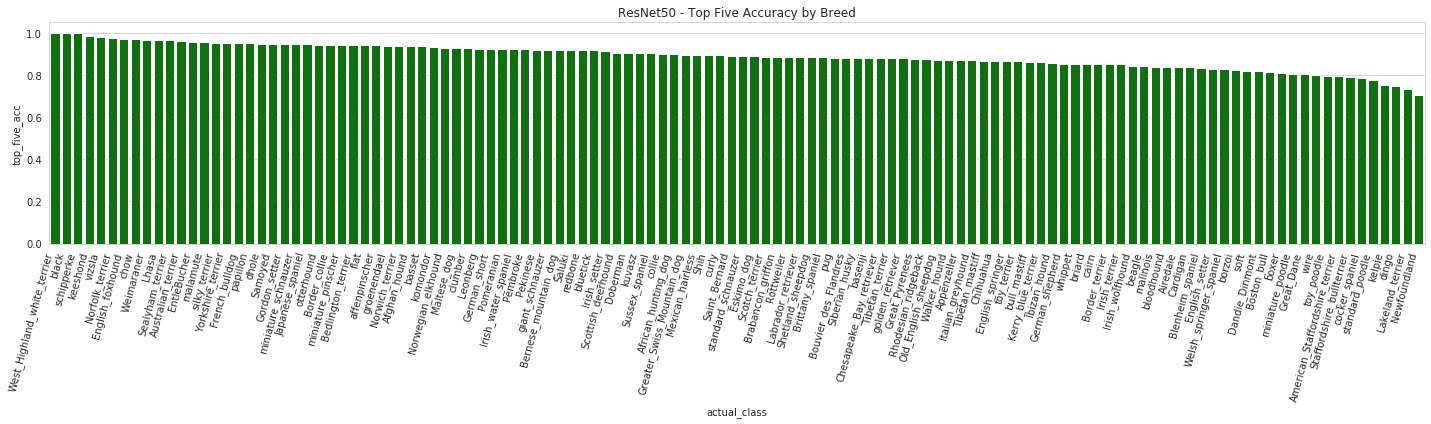

In [51]:
fig, ax = plt.subplots(figsize = (20,6))
sns.set_style("whitegrid")
order = acc_by_breed["top_five_acc"].sort_values(ascending = False).index.tolist()
acc_plot = sns.barplot(x = "actual_class", 
            y = "top_five_acc", 
            order = order,
            color = "green",
            ci = None,
            ax = ax,
            n_boot = None,
            data = test_df)
acc_plot.set_xticklabels(acc_plot.get_xticklabels(),
                         rotation = 75,
                         ha= 'right'
                        )
plt.title("ResNet50 - Top Five Accuracy by Breed")
plt.tight_layout()

- Half of the breeds are between 80 and 90% top-5 accuracy
- Just about 40% of the breeds are above 90% top-5 accuracy
- Fewer than 10% are below 80%; none are below 70%

In [52]:
pd.cut(acc_by_breed.top_five_acc, bins = np.linspace(0,1,11), 
       right = False, include_lowest = True).value_counts(normalize = True).sort_index()

[0.0, 0.1)    0.000000
[0.1, 0.2)    0.000000
[0.2, 0.3)    0.000000
[0.3, 0.4)    0.000000
[0.4, 0.5)    0.000000
[0.5, 0.6)    0.000000
[0.6, 0.7)    0.000000
[0.7, 0.8)    0.076923
[0.8, 0.9)    0.487179
[0.9, 1.0)    0.435897
Name: top_five_acc, dtype: float64

## 7. Conclusion

Transfer learning is definitely a much better use of my time than continuing to iterate on my ground up network. 

At least in the case of ResNet50 and GoogLeNet, even doing just 20 epochs to train a new classifier didn't seem to yield overfitting. That's purely a hypothesis at this point though; because I wasn't tracking validation accuracy I don't know for sure. 

It would be interesting to implement a validation set and potentially halt training early could make sure we're getting the most bang for the considerable amount of time it takes to train these. That would 100% be my next experiment.

But I would only even consider doing it if my `ml.p2.xlarge` hosting increase comes through. Getting predictions out of some of these networks (LOOKING AT YOU VGG16) without a GPU is a significant chunk of time. It may also be worth exploring whether a BatchTransform job is a better course of action for evaluation.

I should also probably think about abstracting some of the functions that work with `test_df` into a separate file, like I did with my pre-processing method.

**Other Open Question:** Are these models getting high accuracy on the same breeds? What's the 10 most-accurate aand 10 least-accurate for each model, and what does the overlap look like?